In [11]:
""" Implementing training confidence calibrated classifier paper for synthetic data experiment """

import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, Lambda
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import matplotlib.pyplot as plt


from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

In [12]:

class GAN(object):

    """ Generative Adversarial Network class """
    def __init__(self):


        self.number_of_classes = 2
        self.input_dim = 2
        self.gen_input_dim = 100
        self.epochs = 20000
        self.batch_size = 200
        self.save_interval = 100
        # There are 2 inlier circles
        # Inlier circle centers on the 1st axis; for all other dimensions, the centers are at 0.
        self.x1 = 0.1
        self.x2 = 0.8
        self.r = 0.1
        # Number of inlier samples for each class
        self.n = 1000
        # width of the outlier outer square side
        self.s = 100

        # Confidence loss weight
        self.beta_G = 1.0
        self.beta_C = 0.5
        # get in-distribution data from 2 circles (2 classes)
        self.data, self.labels = self.get_data()

        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)

        self.Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        self.Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)

        self.optimizer = Adam(lr=0.000002, beta_1=0.5, decay=1e-4)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.C = self.__classifier()
        self.C.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00002, beta_1=0.5, decay=1e-4), metrics=['accuracy'])

        self.stacked_generator_discriminator_classifier = self.__stacked_generator_discriminator_classifier()
        self.stacked_generator_discriminator_classifier.compile(loss={'out_d':'binary_crossentropy', 'out_c':'categorical_crossentropy'}, 
                                       loss_weights={'out_d': 1.0, 'out_c': self.beta_G}, optimizer=self.optimizer, 
                                       metrics={'out_d':['acc'], 'out_c':['categorical_crossentropy']})





    # sample points from 2D gaussian centered at origin
    def sample_point_from_gaussian(self, sigma):
        mean = np.zeros(self.input_dim)
        cov = np.zeros((self.input_dim, self.input_dim), np.float32)
        np.fill_diagonal(cov, sigma*sigma)
        p = list(np.random.multivariate_normal(mean, cov, 1).T.squeeze())
        return p

        
    # sample from a hypersphre with rejection sampling
    def get_gaussian_data(self, x, r, n):
        data = np.zeros((n, self.input_dim))
        count = 0
        while count<n:
            data[count, :] = self.sample_point_from_gaussian(r)
            # update the point with offset for the 1st dimension
            data[count, 0] += x
            count += 1

        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)

    
    def get_data(self):
        # class 0 data
        data = self.get_gaussian_data(self.x1, self.r, self.n)
        labels = np.ones((self.n, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_gaussian_data(self.x2, self.r, self.n)), axis=0)
        labels = np.concatenate((labels, np.ones((self.n, 1))*1), axis=0)
        print(labels.shape)

        return data.astype(np.float32), labels.astype(np.float32)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(self.gen_input_dim,)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.input_dim, activation='linear'))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Dense(256, input_shape=(self.input_dim, )))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    
    """
    def __generator(self):
        # Declare generator 

        model = Sequential()
        model.add(Dense(500, input_shape=(self.gen_input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.input_dim, activation='linear'))

        return model

    def __discriminator(self):
        # Declare discriminator

        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim, )))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model
    """

    def __classifier(self):
        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        model.add(Activation('softmax'))
        return model


    def __stacked_generator_discriminator_classifier(self):
        self.D.trainable = False
        self.C.trainalble = False

        # generator input
        in_g = Input(shape=(self.gen_input_dim, ))
        # generator output
        out_g = self.G(in_g)

        # discriminator output
        out_d = self.D(out_g)
        # classifier output
        out_c = self.C(out_g)

        out_d = Lambda(lambda x: x, name = 'out_d')(out_d)
        out_c = Lambda(lambda x: x, name = 'out_c')(out_c)

        model = Model(inputs=[in_g], outputs=[out_d, out_c])
        return model


    def train(self):

        # gen_data = np.empty((self.epochs*10, self.input_dim))
        # count = 0
        y_discriminator_ones = np.ones((self.batch_size/2, 1)).astype(np.float32)
        y_discriminator_zeros = np.zeros((self.batch_size/2, 1)).astype(np.float32)
        y_out = np.ones((self.batch_size/2, 2)).astype(np.float32)
        sample_weight = np.ones((self.batch_size)).astype(np.float32)
        sample_weight[self.batch_size/2:] = self.beta_C

        for cnt in range(self.epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(self.X_train) - self.batch_size/2)
            legit_images = self.X_train[random_index : random_index + self.batch_size/2]

            gen_noise = np.random.normal(0, 1, (self.batch_size/2, self.gen_input_dim))
            synthetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, synthetic_images))
            y_combined_batch = np.concatenate((y_discriminator_ones, y_discriminator_zeros))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            """
            gen_noise = np.random.normal(0, 1, (100, 100))
            syntetic_images = self.G.predict(gen_noise)
            preds = self.D.predict(syntetic_images)
            ind = np.where(preds < self.thresh)[0]
            if len(ind) > 0:
                gen_data[count:count+min(10, ind.shape[0]),] = syntetic_images[ind[0:min(10, ind.shape[0])],]
                count = count + min(10, ind.shape[0])
            """

            # train generator
            noise = np.random.normal(0, 1, (self.batch_size/2, self.gen_input_dim))
            g_loss = self.stacked_generator_discriminator_classifier.train_on_batch([noise], [y_discriminator_ones, y_out])

            # train classifier
            random_index = np.random.randint(0, len(self.X_train) - self.batch_size/2)
            legit_images = self.X_train[random_index : random_index + self.batch_size/2]
            legit_labels = self.Y_train[random_index : random_index + self.batch_size/2]

            gen_noise = np.random.normal(0, 1, (self.batch_size/2, self.gen_input_dim))
            synthetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, synthetic_images))
            y_combined_batch = np.concatenate((legit_labels, y_out))

            c_loss = self.C.train_on_batch(x_combined_batch, y_combined_batch, sample_weight=sample_weight)
            #print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f], [ Classifier :: loss: %f]' % 
            #       (cnt, d_loss[0], g_loss, 10.1))

            if cnt % self.save_interval == 0:
                print('epoch: %d' % cnt)
                print("d_loss", d_loss)
                print("g_loss", g_loss)
                c_loss = self.C.evaluate(self.X_test, self.Y_test)
                print("c_loss:", c_loss)
                self.plot_data(save2file=True, step=cnt)



    def plot_data(self, save2file, step=0):
        ''' Plot and generated images '''

        gen_noise = np.random.normal(0, 1, (self.X_test.shape[0], self.gen_input_dim))
        synthetic_images = self.G.predict(gen_noise)


        plt.figure(figsize=(5,5))
        ind = np.where(self.y_test == 0)[0]
        plt.scatter(self.X_test[ind, 0], self.X_test[ind, 1], s=10, c='#FFA500', marker='D')
        ind = np.where(self.y_test == 1)[0]
        plt.scatter(self.X_test[ind, 0], self.X_test[ind, 1], s=10, c='b', marker='o')
        plt.scatter(synthetic_images[:, 0], synthetic_images[:, 1], s=10, c='#FFFF33', marker='*')
        plt.legend(('$class\ 0$','$class\ 1$','$OOD\ sample$'), fontsize='x-small');

        if save2file:
            filename = "./images/mnist_%d.png" % step
            plt.savefig(filename)
        plt.show()
        plt.close('all')


        

(1000, 1)
(2000, 1)
((2000, 2), (2000, 1))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 256)               768       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (Non

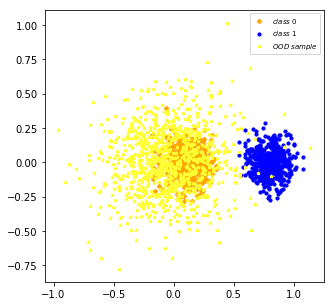

epoch: 100
('d_loss', [0.68991697, 0.69])
('g_loss', [2.081585, 0.6931, 1.3884848, 0.41, 1.3884848])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.6204237060546876, 0.712])


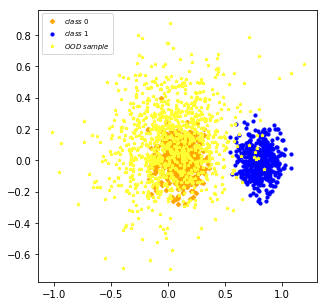

epoch: 200
('d_loss', [0.6883109, 0.595])
('g_loss', [2.0854466, 0.68614, 1.3993067, 0.78, 1.3993067])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.5607370901107788, 0.866])


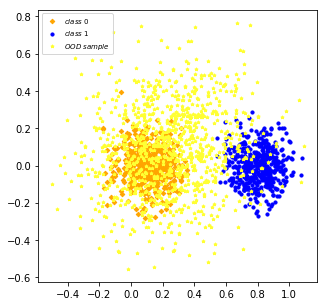

epoch: 300
('d_loss', [0.6895657, 0.5])
('g_loss', [2.0987797, 0.6854452, 1.4133344, 0.72, 1.4133344])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.4926580500602722, 0.954])


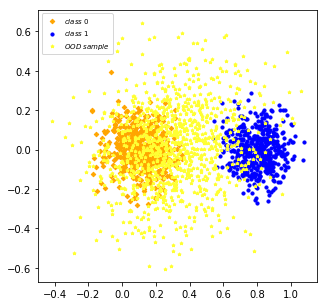

epoch: 400
('d_loss', [0.69104165, 0.44])
('g_loss', [2.1079464, 0.6818826, 1.4260639, 0.82, 1.4260639])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.41687125420570376, 0.99])


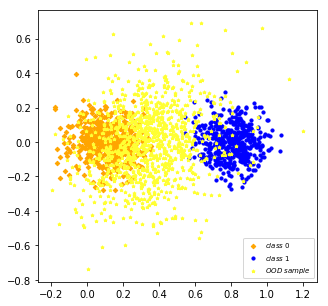

epoch: 500
('d_loss', [0.6902426, 0.42])
('g_loss', [2.129021, 0.6793769, 1.449644, 0.87, 1.449644])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.3387892694473267, 0.997])


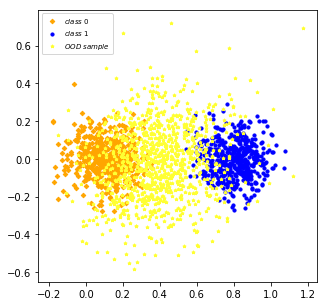

epoch: 600
('d_loss', [0.6893814, 0.44])
('g_loss', [2.1444855, 0.6815697, 1.4629158, 0.87, 1.4629158])
1000/1000 [==============================] - 0s 25us/step
('c_loss:', [0.2699618306159973, 0.999])


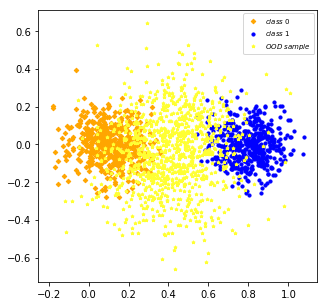

epoch: 700
('d_loss', [0.69003975, 0.42])
('g_loss', [2.187264, 0.6819472, 1.5053167, 0.8, 1.5053167])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.21879072022438048, 1.0])


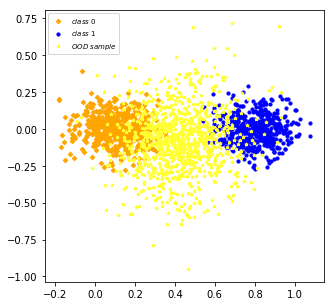

epoch: 800
('d_loss', [0.68718046, 0.505])
('g_loss', [2.1909378, 0.68905264, 1.5018852, 0.59, 1.5018852])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.18077255725860597, 1.0])


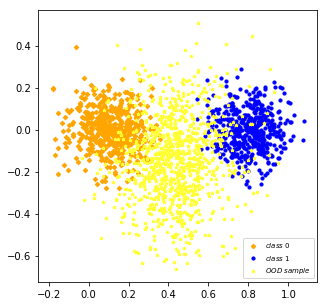

epoch: 900
('d_loss', [0.678587, 0.67])
('g_loss', [2.1965723, 0.7095351, 1.4870373, 0.29, 1.4870373])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.150338782787323, 1.0])


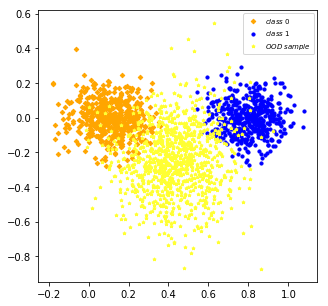

epoch: 1000
('d_loss', [0.66353714, 0.77])
('g_loss', [2.1721902, 0.7345529, 1.4376372, 0.16, 1.4376372])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.12214509475231171, 1.0])


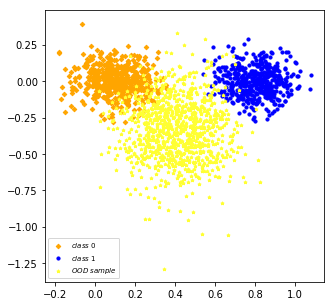

epoch: 1100
('d_loss', [0.6496553, 0.825])
('g_loss', [2.1911407, 0.7680661, 1.4230746, 0.03, 1.4230746])
1000/1000 [==============================] - 0s 23us/step
('c_loss:', [0.09905176770687103, 1.0])


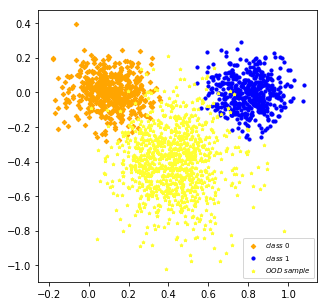

epoch: 1200
('d_loss', [0.6307776, 0.89])
('g_loss', [2.2624123, 0.78257096, 1.4798414, 0.03, 1.4798414])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.08137042352557182, 1.0])


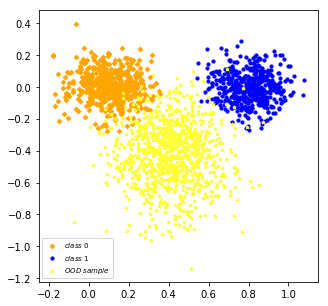

epoch: 1300
('d_loss', [0.63217425, 0.85])
('g_loss', [2.242966, 0.8016346, 1.4413314, 0.04, 1.4413314])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.06871169379353523, 1.0])


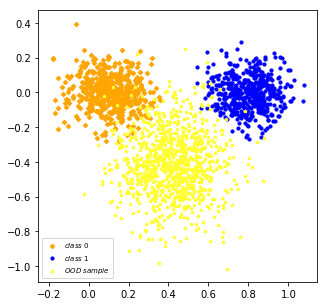

epoch: 1400
('d_loss', [0.6272873, 0.855])
('g_loss', [2.2673247, 0.8088066, 1.458518, 0.05, 1.458518])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.060927205741405484, 1.0])


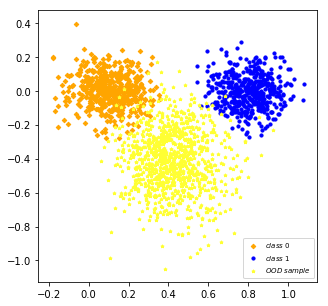

epoch: 1500
('d_loss', [0.6183293, 0.885])
('g_loss', [2.260696, 0.81157553, 1.4491205, 0.06, 1.4491205])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.05432654863595963, 1.0])


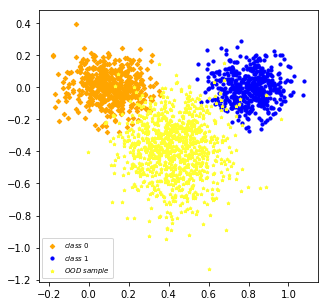

epoch: 1600
('d_loss', [0.62170553, 0.825])
('g_loss', [2.2480555, 0.8336088, 1.4144466, 0.03, 1.4144466])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.050186443105340005, 1.0])


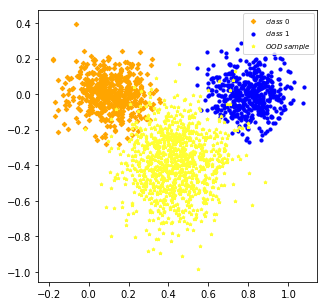

epoch: 1700
('d_loss', [0.6207763, 0.82])
('g_loss', [2.273841, 0.8434004, 1.4304404, 0.05, 1.4304404])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.04705375508964062, 1.0])


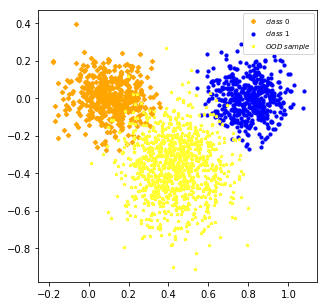

epoch: 1800
('d_loss', [0.61071414, 0.85])
('g_loss', [2.2617724, 0.84334654, 1.4184258, 0.06, 1.4184258])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.045781717032194136, 1.0])


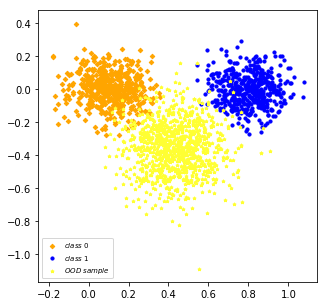

epoch: 1900
('d_loss', [0.60868883, 0.86])
('g_loss', [2.2935154, 0.83132845, 1.462187, 0.06, 1.462187])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.04522136649489403, 1.0])


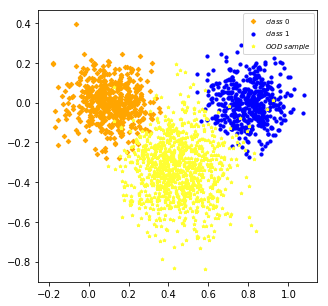

epoch: 2000
('d_loss', [0.60319525, 0.875])
('g_loss', [2.3124974, 0.8180795, 1.4944179, 0.13, 1.4944179])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.0444507198035717, 1.0])


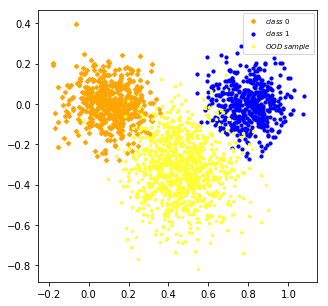

epoch: 2100
('d_loss', [0.6061472, 0.835])
('g_loss', [2.2654262, 0.83133966, 1.4340864, 0.09, 1.4340864])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.0451658496260643, 1.0])


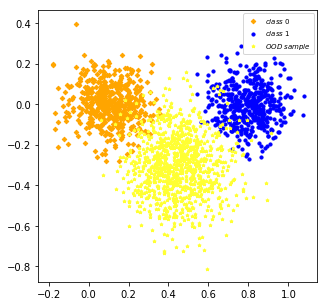

epoch: 2200
('d_loss', [0.59998286, 0.855])
('g_loss', [2.2726955, 0.849552, 1.4231435, 0.05, 1.4231435])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.04490711854398251, 1.0])


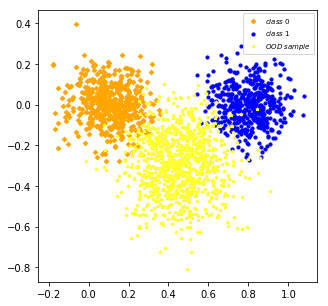

epoch: 2300
('d_loss', [0.60753804, 0.83])
('g_loss', [2.2818544, 0.82334304, 1.4585114, 0.11, 1.4585114])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.04511424565315247, 1.0])


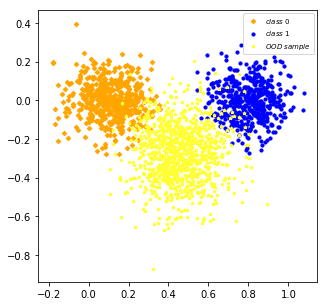

epoch: 2400
('d_loss', [0.60288155, 0.825])
('g_loss', [2.2724094, 0.8330358, 1.4393736, 0.09, 1.4393736])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.04552162297070026, 1.0])


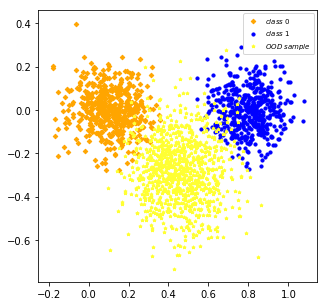

epoch: 2500
('d_loss', [0.5981089, 0.84])
('g_loss', [2.2894225, 0.84384227, 1.4455801, 0.12, 1.4455801])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.04573048271238804, 1.0])


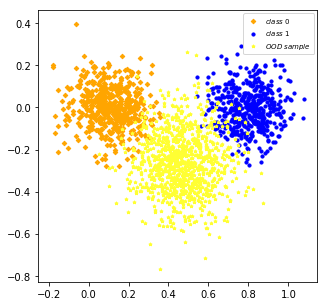

epoch: 2600
('d_loss', [0.60123724, 0.81])
('g_loss', [2.2675223, 0.8271735, 1.440349, 0.11, 1.440349])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.04672476842999458, 1.0])


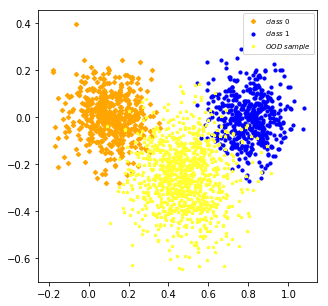

epoch: 2700
('d_loss', [0.5937268, 0.805])
('g_loss', [2.3078368, 0.82505506, 1.4827816, 0.17, 1.4827816])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.049037963941693304, 1.0])


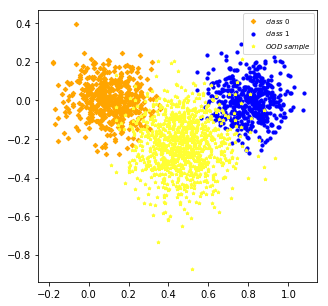

epoch: 2800
('d_loss', [0.61017144, 0.805])
('g_loss', [2.3144288, 0.81930304, 1.4951258, 0.16, 1.4951258])
1000/1000 [==============================] - 0s 23us/step
('c_loss:', [0.051110344886779784, 1.0])


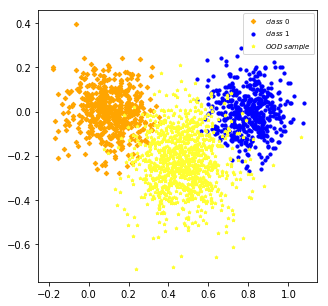

epoch: 2900
('d_loss', [0.6168309, 0.75])
('g_loss', [2.3023882, 0.8395436, 1.4628447, 0.16, 1.4628447])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.053247380256652835, 1.0])


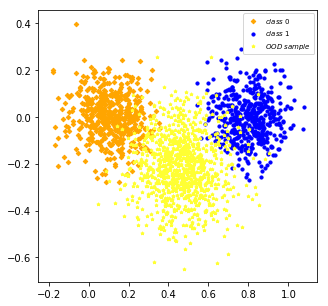

epoch: 3000
('d_loss', [0.60382646, 0.795])
('g_loss', [2.3027086, 0.831053, 1.4716556, 0.1, 1.4716556])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.05394162786006927, 1.0])


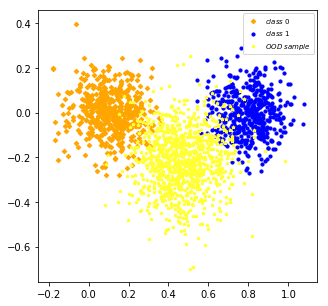

epoch: 3100
('d_loss', [0.6067373, 0.8])
('g_loss', [2.2798438, 0.8161373, 1.4637065, 0.19, 1.4637065])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.0556078385412693, 1.0])


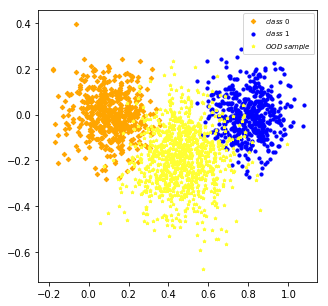

epoch: 3200
('d_loss', [0.6177107, 0.74])
('g_loss', [2.292798, 0.8116888, 1.4811091, 0.21, 1.4811091])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.056239365220069885, 1.0])


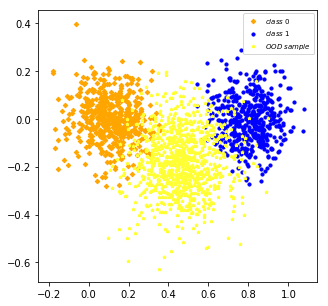

epoch: 3300
('d_loss', [0.6103312, 0.775])
('g_loss', [2.3146129, 0.8192897, 1.4953231, 0.18, 1.4953231])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.05753724846243859, 1.0])


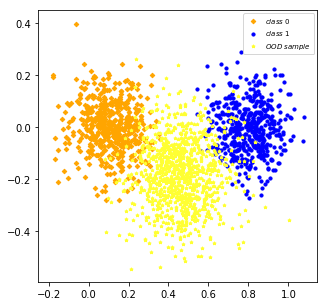

epoch: 3400
('d_loss', [0.6171589, 0.74])
('g_loss', [2.3585486, 0.81942785, 1.5391209, 0.19, 1.5391209])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.061727045506238934, 1.0])


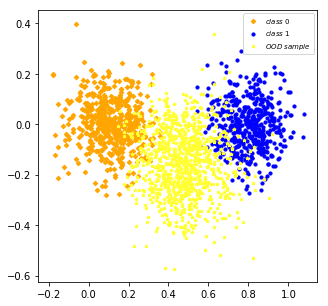

epoch: 3500
('d_loss', [0.61433595, 0.71])
('g_loss', [2.2952862, 0.7991434, 1.4961427, 0.3, 1.4961427])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06380851589143276, 1.0])


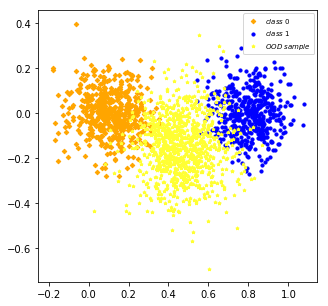

epoch: 3600
('d_loss', [0.616282, 0.735])
('g_loss', [2.3285594, 0.7680683, 1.5604912, 0.34, 1.5604912])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.06772441607713699, 1.0])


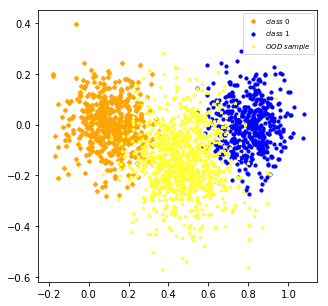

epoch: 3700
('d_loss', [0.6308892, 0.735])
('g_loss', [2.2809982, 0.7931886, 1.4878097, 0.28, 1.4878097])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.0687187923938036, 1.0])


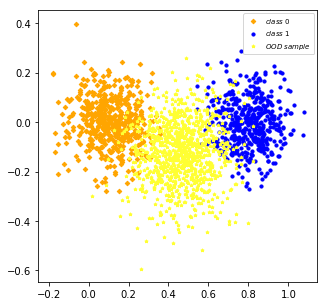

epoch: 3800
('d_loss', [0.6356297, 0.67])
('g_loss', [2.2768188, 0.773105, 1.5037138, 0.36, 1.5037138])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06963961234688759, 1.0])


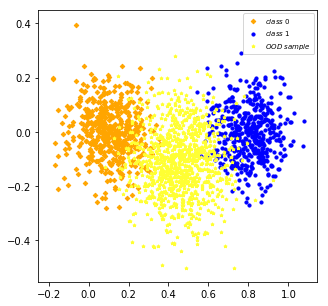

epoch: 3900
('d_loss', [0.63880897, 0.67])
('g_loss', [2.3446717, 0.78637993, 1.5582919, 0.32, 1.5582919])
1000/1000 [==============================] - 0s 23us/step
('c_loss:', [0.07724554112553597, 1.0])


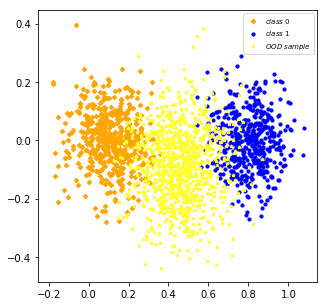

epoch: 4000
('d_loss', [0.65533835, 0.645])
('g_loss', [2.210445, 0.7447876, 1.4656574, 0.44, 1.4656574])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.08155305872857571, 1.0])


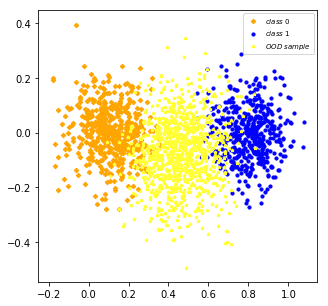

epoch: 4100
('d_loss', [0.6653061, 0.585])
('g_loss', [2.2462485, 0.7108399, 1.5354086, 0.49, 1.5354086])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.08633685722947121, 1.0])


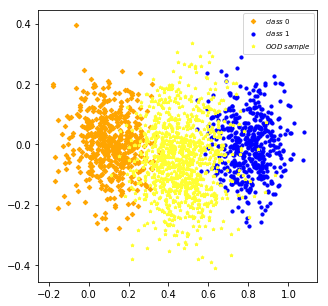

epoch: 4200
('d_loss', [0.6860733, 0.54])
('g_loss', [2.2591348, 0.68255264, 1.5765822, 0.66, 1.5765822])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.0890185405910015, 1.0])


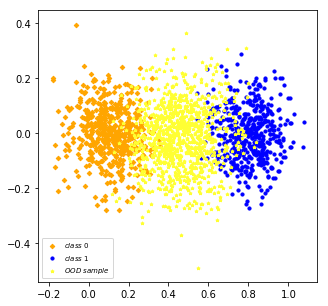

epoch: 4300
('d_loss', [0.71786714, 0.435])
('g_loss', [2.2706943, 0.6527726, 1.6179217, 0.68, 1.6179217])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.09036902207136153, 1.0])


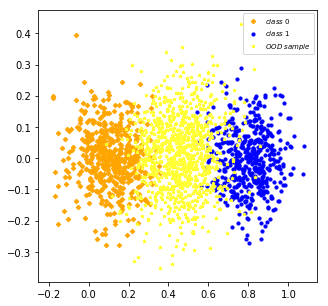

epoch: 4400
('d_loss', [0.72145784, 0.445])
('g_loss', [2.1787875, 0.63991076, 1.5388767, 0.71, 1.5388767])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.09440703064203262, 1.0])


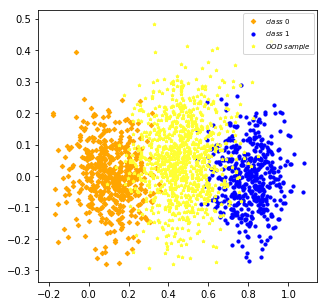

epoch: 4500
('d_loss', [0.7319838, 0.42])
('g_loss', [2.1821442, 0.5798189, 1.6023253, 0.88, 1.6023253])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.09454643774032592, 1.0])


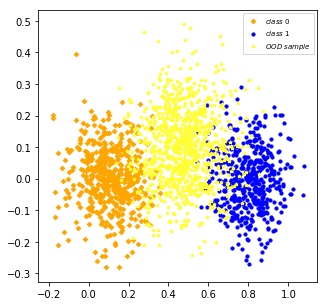

epoch: 4600
('d_loss', [0.7672046, 0.325])
('g_loss', [2.0626101, 0.5639398, 1.4986705, 0.92, 1.4986705])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.09046444138884545, 1.0])


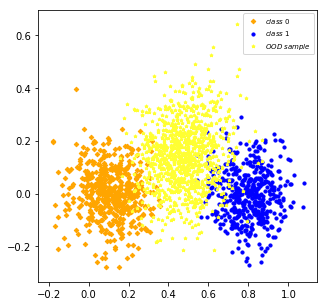

epoch: 4700
('d_loss', [0.7777817, 0.295])
('g_loss', [2.075254, 0.5503795, 1.5248746, 0.94, 1.5248746])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.0863251983821392, 1.0])


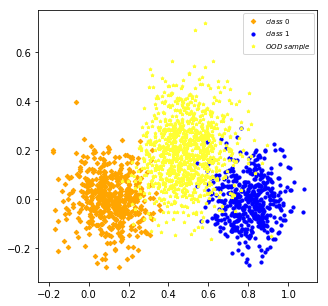

epoch: 4800
('d_loss', [0.7696933, 0.305])
('g_loss', [2.0525362, 0.54308516, 1.509451, 1.0, 1.509451])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.07995564061403275, 1.0])


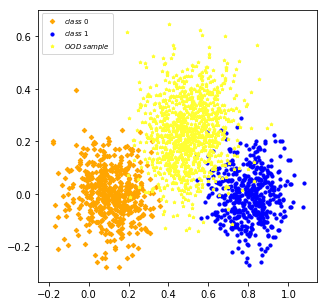

epoch: 4900
('d_loss', [0.79033935, 0.31])
('g_loss', [2.0402462, 0.5287344, 1.5115118, 0.96, 1.5115118])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.07086403754353524, 1.0])


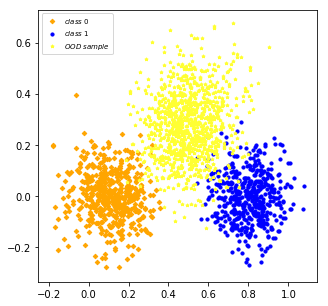

epoch: 5000
('d_loss', [0.78017515, 0.325])
('g_loss', [2.03827, 0.5182042, 1.5200658, 1.0, 1.5200658])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.0650079385638237, 1.0])


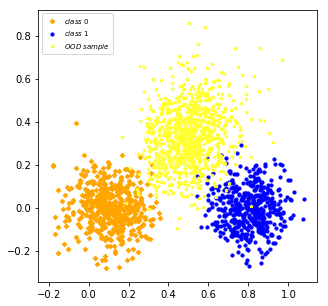

epoch: 5100
('d_loss', [0.78759444, 0.31])
('g_loss', [1.9568385, 0.51385474, 1.4429837, 1.0, 1.4429837])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.059676959186792375, 1.0])


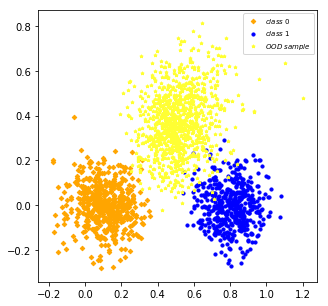

epoch: 5200
('d_loss', [0.7848103, 0.34])
('g_loss', [1.9687521, 0.51952255, 1.4492296, 1.0, 1.4492296])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.05168411000072956, 1.0])


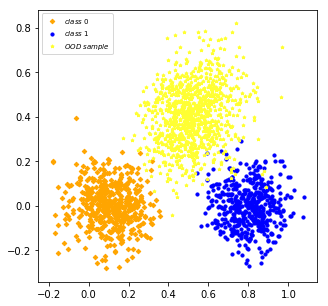

epoch: 5300
('d_loss', [0.7835043, 0.335])
('g_loss', [1.9844863, 0.5228038, 1.4616826, 1.0, 1.4616826])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.04603454053401947, 1.0])


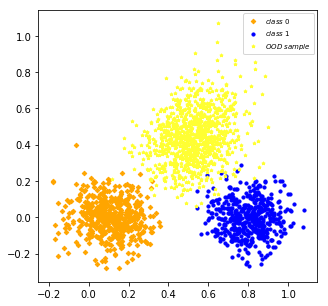

epoch: 5400
('d_loss', [0.781747, 0.33])
('g_loss', [1.9695073, 0.52227366, 1.4472337, 1.0, 1.4472337])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.041180037304759026, 1.0])


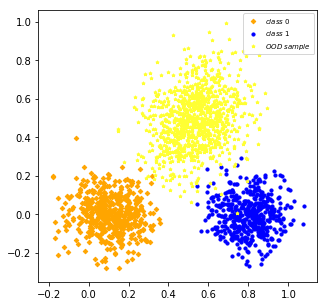

epoch: 5500
('d_loss', [0.78187037, 0.34])
('g_loss', [1.9548559, 0.5291215, 1.4257344, 1.0, 1.4257344])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.035619532987475395, 1.0])


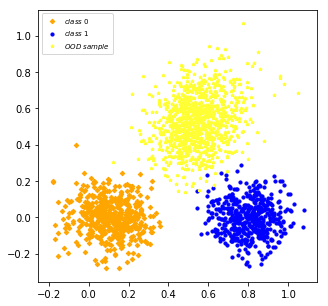

epoch: 5600
('d_loss', [0.77473974, 0.32])
('g_loss', [1.9376088, 0.5298679, 1.407741, 1.0, 1.407741])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.031578505471348765, 1.0])


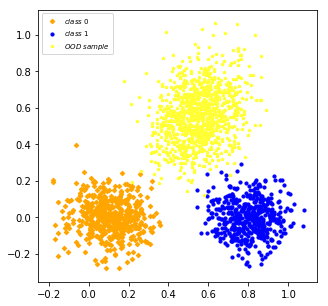

epoch: 5700
('d_loss', [0.773622, 0.345])
('g_loss', [1.9438765, 0.53591746, 1.407959, 1.0, 1.407959])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.02745344468206167, 1.0])


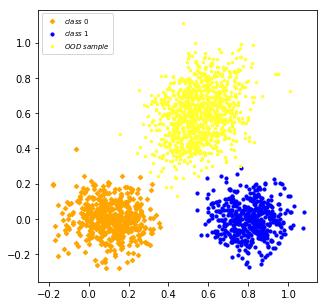

epoch: 5800
('d_loss', [0.7663253, 0.335])
('g_loss', [1.9685843, 0.5437605, 1.4248239, 1.0, 1.4248239])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.024346928358078, 1.0])


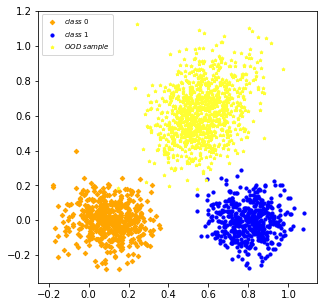

epoch: 5900
('d_loss', [0.75976026, 0.375])
('g_loss', [1.9685352, 0.55474037, 1.4137949, 1.0, 1.4137949])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.021097533777356146, 1.0])


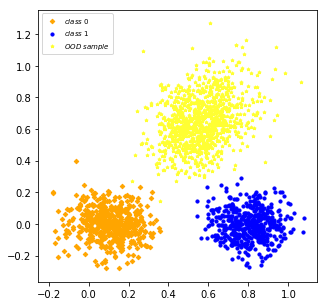

epoch: 6000
('d_loss', [0.7546548, 0.37])
('g_loss', [1.9589772, 0.56269497, 1.3962822, 1.0, 1.3962822])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.018526487782597544, 1.0])


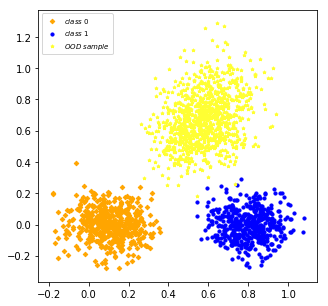

epoch: 6100
('d_loss', [0.75116676, 0.37])
('g_loss', [1.9707592, 0.5732115, 1.3975476, 1.0, 1.3975476])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.016318825274705885, 1.0])


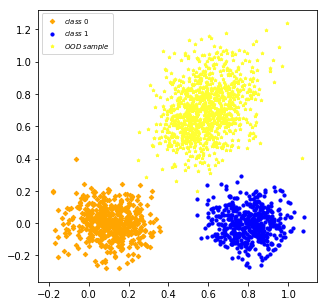

epoch: 6200
('d_loss', [0.7451248, 0.34])
('g_loss', [1.9844973, 0.58575785, 1.3987395, 1.0, 1.3987395])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.014329491689801216, 1.0])


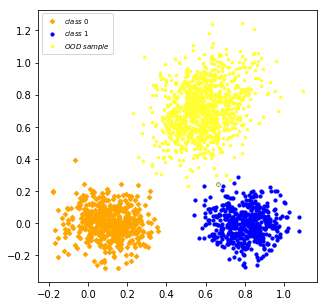

epoch: 6300
('d_loss', [0.73241377, 0.365])
('g_loss', [1.9840639, 0.5953838, 1.3886801, 1.0, 1.3886801])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.012730774741619825, 1.0])


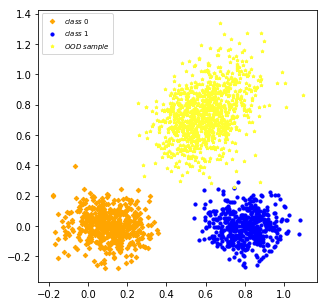

epoch: 6400
('d_loss', [0.73075813, 0.35])
('g_loss', [2.009716, 0.604289, 1.4054271, 1.0, 1.4054271])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.011393726333975791, 1.0])


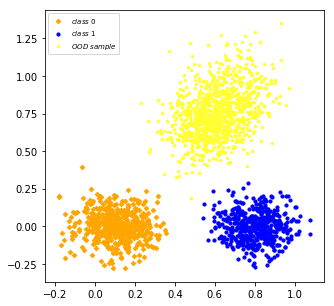

epoch: 6500
('d_loss', [0.7240124, 0.355])
('g_loss', [2.0036507, 0.61656725, 1.3870835, 1.0, 1.3870835])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.010109724972397089, 1.0])


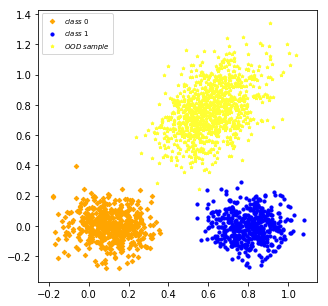

epoch: 6600
('d_loss', [0.71430266, 0.395])
('g_loss', [2.0226197, 0.62771344, 1.3949062, 1.0, 1.3949062])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.009134732827544212, 1.0])


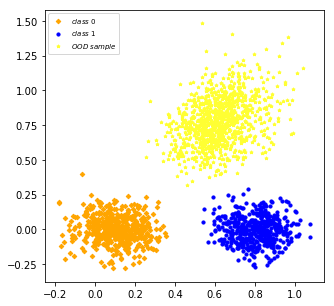

epoch: 6700
('d_loss', [0.7106408, 0.385])
('g_loss', [2.032043, 0.6409305, 1.3911126, 1.0, 1.3911126])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.008315117947757245, 1.0])


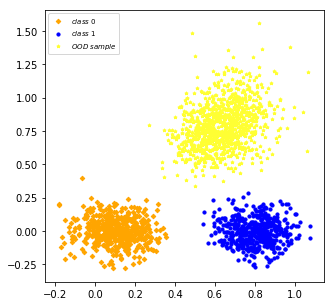

epoch: 6800
('d_loss', [0.69855064, 0.405])
('g_loss', [2.0380175, 0.6498155, 1.388202, 1.0, 1.388202])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.007555624544620514, 1.0])


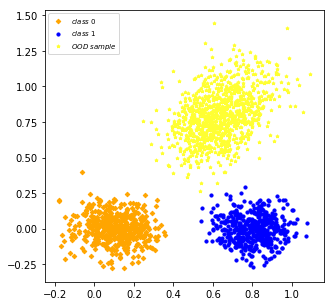

epoch: 6900
('d_loss', [0.69179636, 0.42])
('g_loss', [2.0482066, 0.6606459, 1.3875607, 1.0, 1.3875607])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.006882757745683193, 1.0])


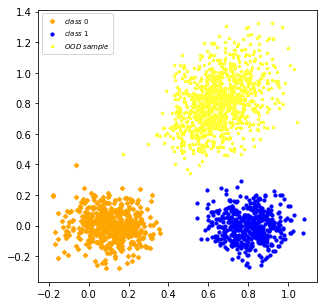

epoch: 7000
('d_loss', [0.69285005, 0.375])
('g_loss', [2.0634658, 0.6714009, 1.3920649, 1.0, 1.3920649])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.00638138347864151, 1.0])


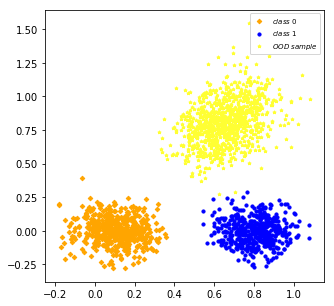

epoch: 7100
('d_loss', [0.684884, 0.42])
('g_loss', [2.070352, 0.6812316, 1.3891203, 0.98, 1.3891203])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.005929328918457031, 1.0])


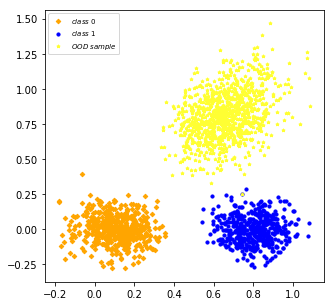

epoch: 7200
('d_loss', [0.6811223, 0.61])
('g_loss', [2.0785723, 0.6904427, 1.3881297, 0.51, 1.3881297])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.005566829595714808, 1.0])


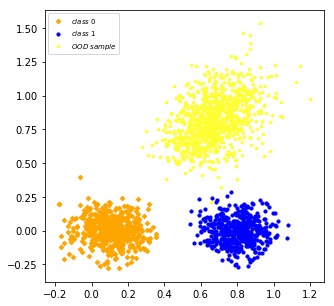

epoch: 7300
('d_loss', [0.66947675, 0.84])
('g_loss', [2.0903058, 0.70155644, 1.3887494, 0.21, 1.3887494])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.005268831221386791, 1.0])


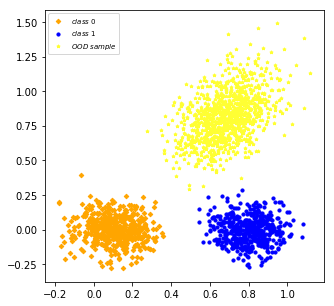

epoch: 7400
('d_loss', [0.6706709, 0.86])
('g_loss', [2.107635, 0.70952874, 1.3981063, 0.17, 1.3981063])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.004966712409630418, 1.0])


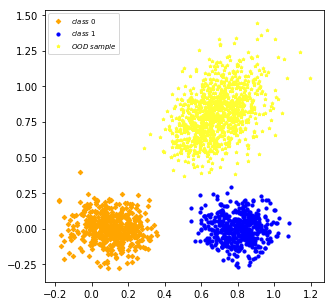

epoch: 7500
('d_loss', [0.6659806, 0.855])
('g_loss', [2.1149845, 0.7213622, 1.3936224, 0.05, 1.3936224])
1000/1000 [==============================] - 0s 23us/step
('c_loss:', [0.004824639014899731, 1.0])


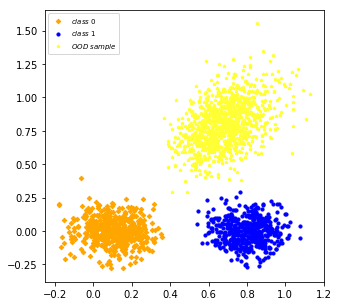

epoch: 7600
('d_loss', [0.65801424, 0.88])
('g_loss', [2.1197498, 0.7310756, 1.3886743, 0.04, 1.3886743])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.00459252543002367, 1.0])


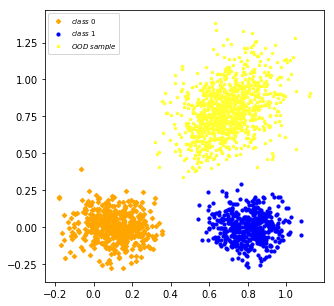

epoch: 7700
('d_loss', [0.65679216, 0.88])
('g_loss', [2.1236057, 0.7371023, 1.3865035, 0.0, 1.3865035])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.004414081286638975, 1.0])


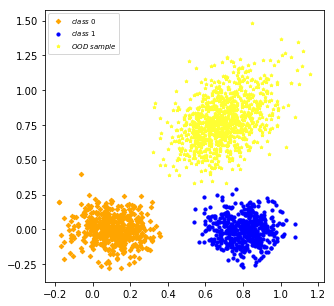

epoch: 7800
('d_loss', [0.65453994, 0.875])
('g_loss', [2.1312137, 0.74439627, 1.3868173, 0.0, 1.3868173])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.0042115150447934865, 1.0])


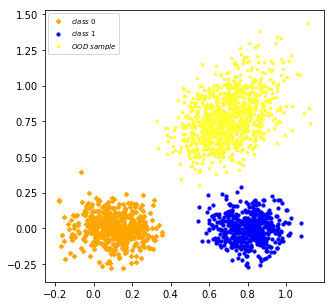

epoch: 7900
('d_loss', [0.6505649, 0.885])
('g_loss', [2.1406085, 0.753001, 1.3876076, 0.0, 1.3876076])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.004244383305311203, 1.0])


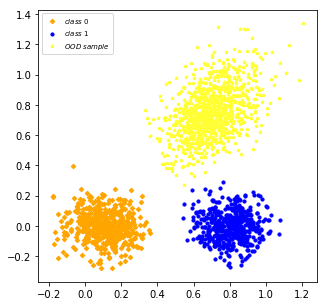

epoch: 8000
('d_loss', [0.64676875, 0.885])
('g_loss', [2.1484594, 0.7561203, 1.3923392, 0.01, 1.3923392])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.004370106477290392, 1.0])


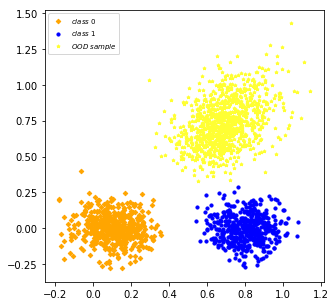

epoch: 8100
('d_loss', [0.6467749, 0.88])
('g_loss', [2.1506658, 0.76228064, 1.388385, 0.0, 1.388385])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.004481416637077928, 1.0])


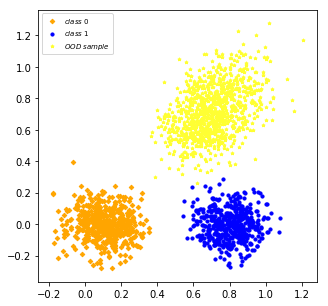

epoch: 8200
('d_loss', [0.6452411, 0.86])
('g_loss', [2.1560137, 0.76646405, 1.3895497, 0.01, 1.3895497])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.004883323245681822, 1.0])


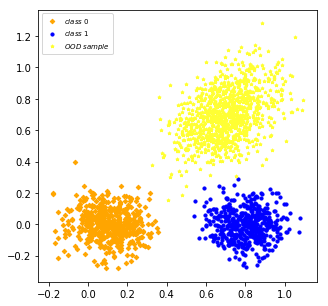

epoch: 8300
('d_loss', [0.63834953, 0.925])
('g_loss', [2.175002, 0.7697744, 1.4052278, 0.03, 1.4052278])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.0049071123618632554, 1.0])


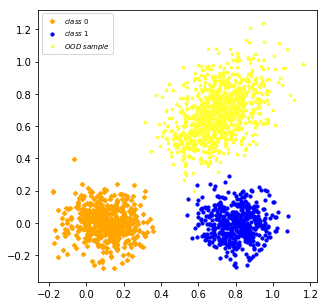

epoch: 8400
('d_loss', [0.6392158, 0.91])
('g_loss', [2.1638122, 0.7768378, 1.3869743, 0.0, 1.3869743])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.004867988558486104, 1.0])


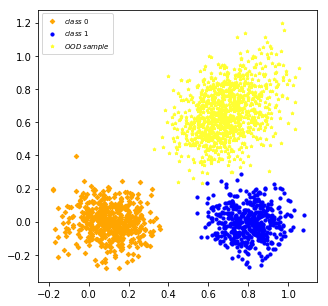

epoch: 8500
('d_loss', [0.63822824, 0.905])
('g_loss', [2.1614294, 0.76968074, 1.3917485, 0.01, 1.3917485])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.005309549748897553, 1.0])


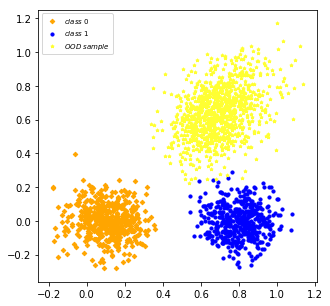

epoch: 8600
('d_loss', [0.640997, 0.89])
('g_loss', [2.191042, 0.78616506, 1.4048768, 0.01, 1.4048768])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.005688993899151683, 1.0])


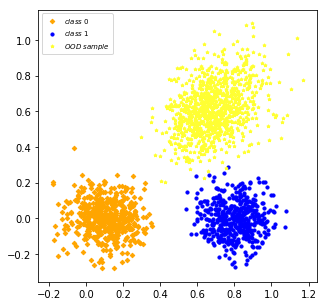

epoch: 8700
('d_loss', [0.629113, 0.93])
('g_loss', [2.1780019, 0.7894525, 1.3885493, 0.0, 1.3885493])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.006044229525141418, 1.0])


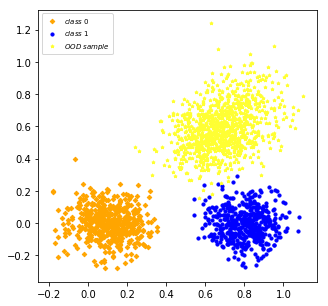

epoch: 8800
('d_loss', [0.63446206, 0.91])
('g_loss', [2.2030153, 0.7815821, 1.4214331, 0.02, 1.4214331])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.006469899989664555, 1.0])


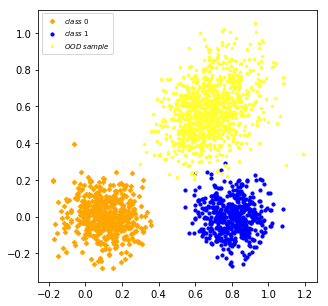

epoch: 8900
('d_loss', [0.631833, 0.935])
('g_loss', [2.1839566, 0.7837626, 1.4001939, 0.03, 1.4001939])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.006987965270876885, 1.0])


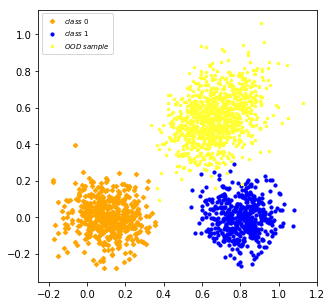

epoch: 9000
('d_loss', [0.63990515, 0.88])
('g_loss', [2.1741567, 0.785107, 1.3890496, 0.0, 1.3890496])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.007335551206022501, 1.0])


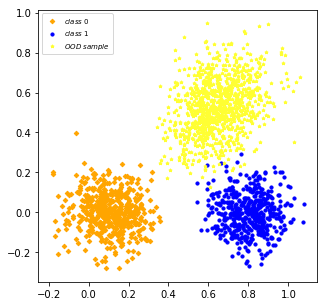

epoch: 9100
('d_loss', [0.63281816, 0.94])
('g_loss', [2.184024, 0.787584, 1.3964401, 0.0, 1.3964401])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.0077451207935810085, 1.0])


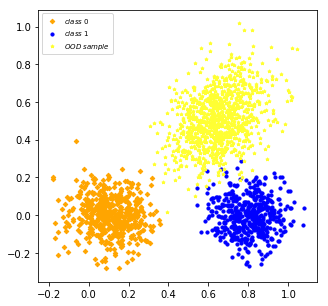

epoch: 9200
('d_loss', [0.6354637, 0.92])
('g_loss', [2.179887, 0.7915216, 1.3883655, 0.0, 1.3883655])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.008373089957982301, 1.0])


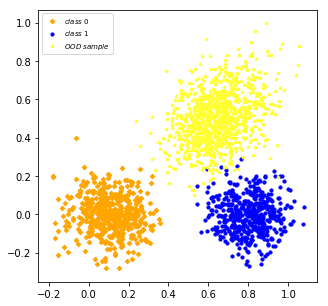

epoch: 9300
('d_loss', [0.6303795, 0.92])
('g_loss', [2.1781642, 0.7898827, 1.3882816, 0.0, 1.3882816])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.00943102989345789, 1.0])


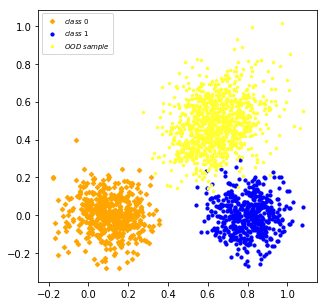

epoch: 9400
('d_loss', [0.6389931, 0.885])
('g_loss', [2.1763406, 0.788292, 1.3880486, 0.0, 1.3880486])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.009750503646209836, 1.0])


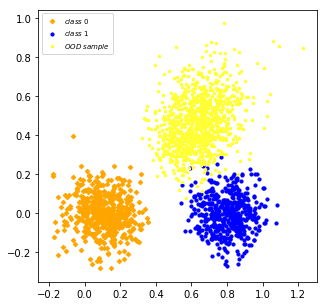

epoch: 9500
('d_loss', [0.6309375, 0.925])
('g_loss', [2.1908257, 0.78811914, 1.4027066, 0.02, 1.4027066])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.009830429039895535, 1.0])


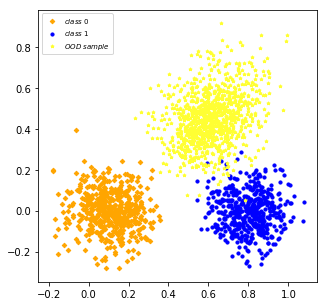

epoch: 9600
('d_loss', [0.63373995, 0.915])
('g_loss', [2.1905284, 0.7992799, 1.3912483, 0.0, 1.3912483])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.010122267574071885, 1.0])


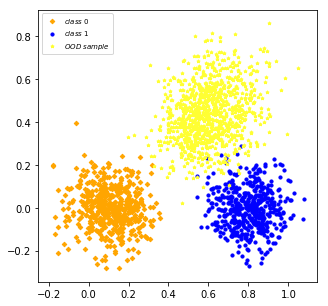

epoch: 9700
('d_loss', [0.6339949, 0.925])
('g_loss', [2.197826, 0.79897904, 1.3988469, 0.01, 1.3988469])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.010709514040499926, 1.0])


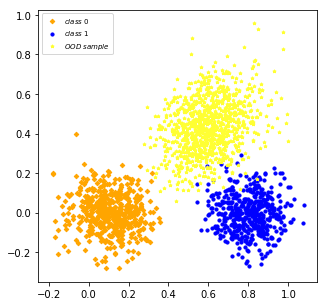

epoch: 9800
('d_loss', [0.62327415, 0.95])
('g_loss', [2.1984239, 0.80113447, 1.3972893, 0.02, 1.3972893])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.010349467888474465, 1.0])


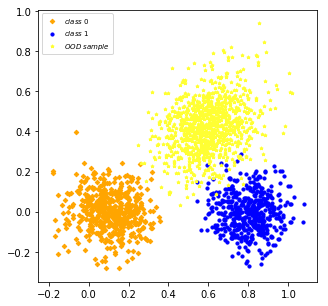

epoch: 9900
('d_loss', [0.6297022, 0.945])
('g_loss', [2.2180948, 0.79893035, 1.4191644, 0.01, 1.4191644])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.010982526071369647, 1.0])


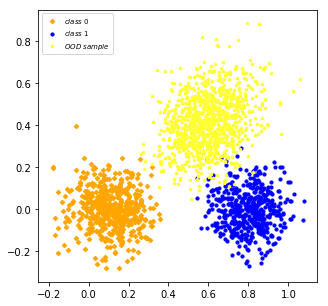

epoch: 10000
('d_loss', [0.63011795, 0.92])
('g_loss', [2.1919215, 0.7958968, 1.3960246, 0.03, 1.3960246])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.012189687175676226, 1.0])


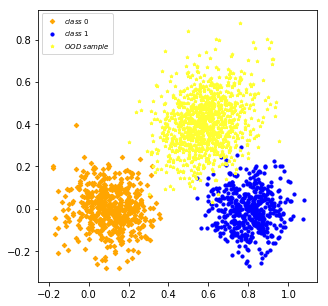

epoch: 10100
('d_loss', [0.6305058, 0.915])
('g_loss', [2.2192824, 0.79232615, 1.4269563, 0.03, 1.4269563])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.01277216751128435, 1.0])


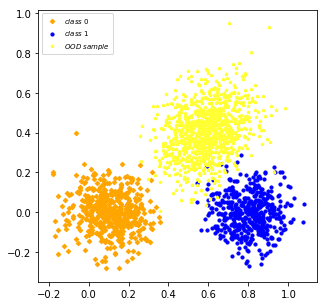

epoch: 10200
('d_loss', [0.6307758, 0.94])
('g_loss', [2.203198, 0.8032016, 1.3999963, 0.01, 1.3999963])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.012576000751927495, 1.0])


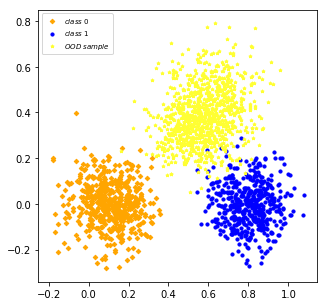

epoch: 10300
('d_loss', [0.6311348, 0.865])
('g_loss', [2.2236073, 0.8040022, 1.4196051, 0.04, 1.4196051])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.012963335700333119, 1.0])


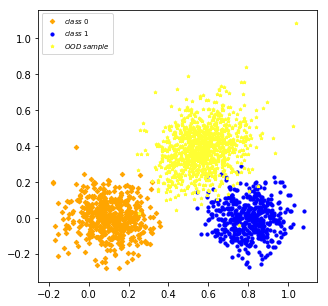

epoch: 10400
('d_loss', [0.6272798, 0.905])
('g_loss', [2.2356715, 0.7970271, 1.4386445, 0.03, 1.4386445])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.012913749732077122, 1.0])


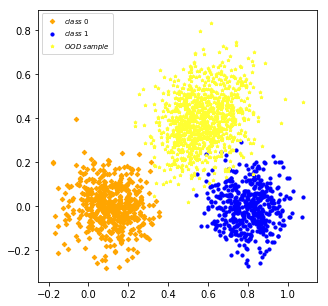

epoch: 10500
('d_loss', [0.62962276, 0.885])
('g_loss', [2.2013197, 0.80469084, 1.396629, 0.02, 1.396629])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.013269437912851572, 1.0])


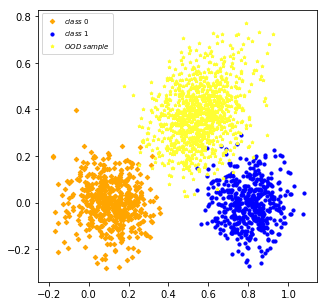

epoch: 10600
('d_loss', [0.6271562, 0.91])
('g_loss', [2.2024324, 0.7989513, 1.403481, 0.04, 1.403481])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.013864927930757403, 1.0])


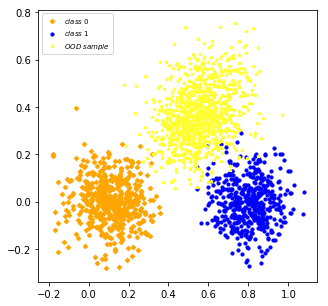

epoch: 10700
('d_loss', [0.62467754, 0.9])
('g_loss', [2.224001, 0.80690736, 1.4170936, 0.03, 1.4170936])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.014049400303512812, 1.0])


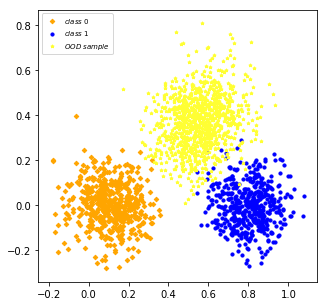

epoch: 10800
('d_loss', [0.62398076, 0.93])
('g_loss', [2.2118242, 0.816495, 1.3953291, 0.0, 1.3953291])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.013941984176635742, 1.0])


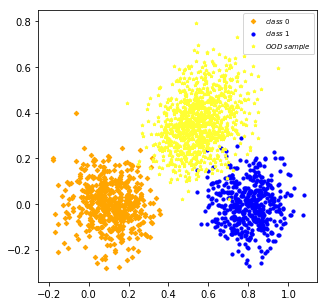

epoch: 10900
('d_loss', [0.62052435, 0.915])
('g_loss', [2.2280045, 0.80964833, 1.4183561, 0.04, 1.4183561])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.014143295988440514, 1.0])


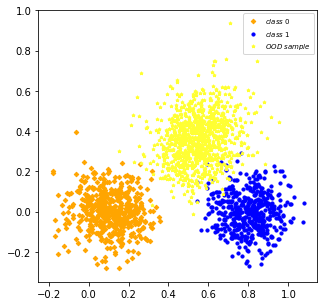

epoch: 11000
('d_loss', [0.625136, 0.915])
('g_loss', [2.2317863, 0.8094605, 1.4223257, 0.04, 1.4223257])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.01470398224517703, 1.0])


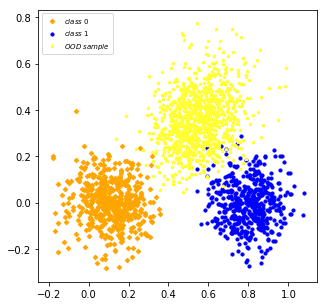

epoch: 11100
('d_loss', [0.6140282, 0.945])
('g_loss', [2.2101197, 0.807975, 1.4021447, 0.04, 1.4021447])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.014908073890954256, 1.0])


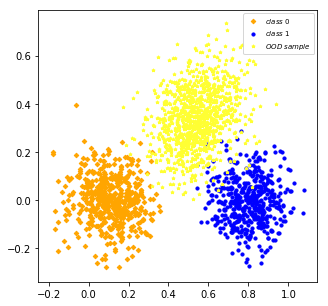

epoch: 11200
('d_loss', [0.6206203, 0.915])
('g_loss', [2.242795, 0.79273677, 1.4500583, 0.08, 1.4500583])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.014788105057552457, 1.0])


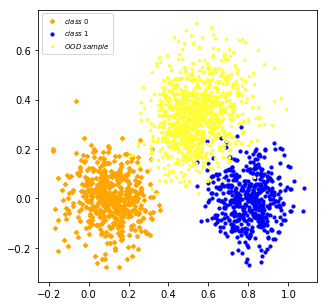

epoch: 11300
('d_loss', [0.6189525, 0.905])
('g_loss', [2.215425, 0.817164, 1.3982611, 0.02, 1.3982611])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.01523479200154543, 1.0])


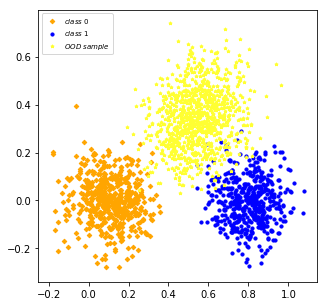

epoch: 11400
('d_loss', [0.61498755, 0.93])
('g_loss', [2.2101061, 0.8101117, 1.3999944, 0.01, 1.3999944])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.015242231803014875, 1.0])


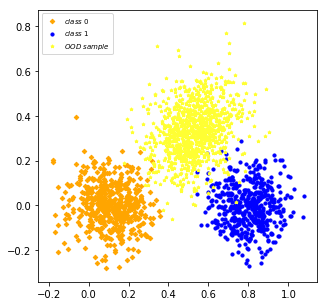

epoch: 11500
('d_loss', [0.61920184, 0.895])
('g_loss', [2.2285328, 0.8149166, 1.4136161, 0.03, 1.4136161])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.01601023370400071, 1.0])


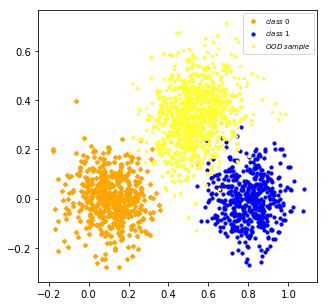

epoch: 11600
('d_loss', [0.60779524, 0.955])
('g_loss', [2.2205048, 0.81464434, 1.4058603, 0.07, 1.4058603])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.016342686085030436, 1.0])


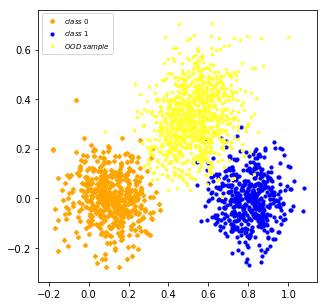

epoch: 11700
('d_loss', [0.61746305, 0.905])
('g_loss', [2.248521, 0.81682867, 1.4316924, 0.05, 1.4316924])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.016374603256583214, 1.0])


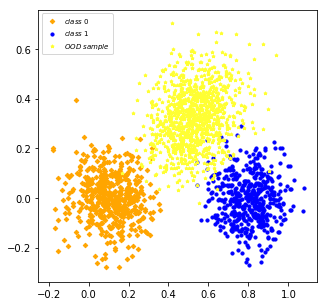

epoch: 11800
('d_loss', [0.61731285, 0.905])
('g_loss', [2.2086654, 0.8205992, 1.388066, 0.0, 1.388066])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.017529355581849815, 1.0])


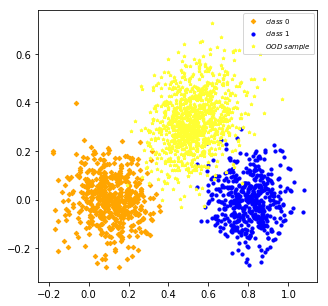

epoch: 11900
('d_loss', [0.6143358, 0.89])
('g_loss', [2.2432313, 0.830523, 1.4127084, 0.01, 1.4127084])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.01700400470942259, 1.0])


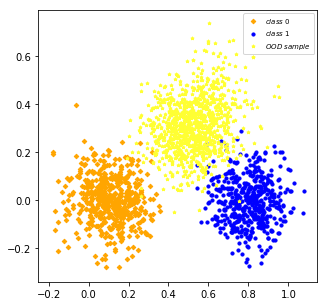

epoch: 12000
('d_loss', [0.6128462, 0.9])
('g_loss', [2.2410808, 0.82824826, 1.4128324, 0.02, 1.4128324])
1000/1000 [==============================] - 0s 17us/step
('c_loss:', [0.017322935573756696, 1.0])


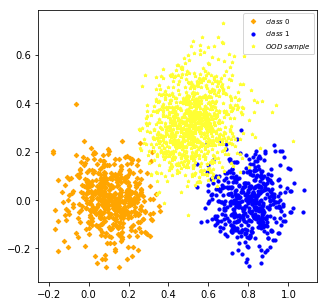

epoch: 12100
('d_loss', [0.6177848, 0.89])
('g_loss', [2.241054, 0.8383179, 1.4027363, 0.02, 1.4027363])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.017105980468913914, 1.0])


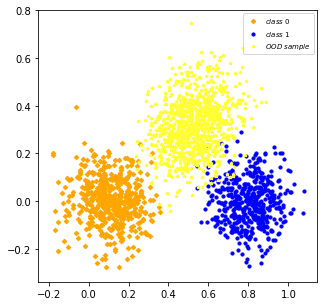

epoch: 12200
('d_loss', [0.60899955, 0.935])
('g_loss', [2.2321227, 0.8093502, 1.4227725, 0.06, 1.4227725])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.018782763611525297, 1.0])


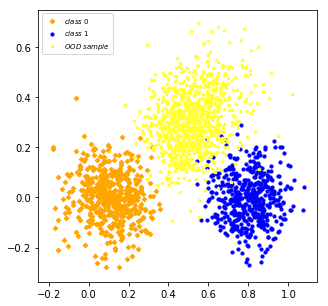

epoch: 12300
('d_loss', [0.61051786, 0.905])
('g_loss', [2.2565856, 0.8179466, 1.438639, 0.04, 1.438639])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.0185162075124681, 1.0])


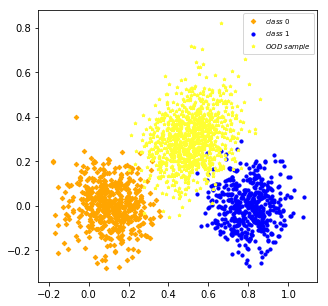

epoch: 12400
('d_loss', [0.60577357, 0.935])
('g_loss', [2.2339084, 0.82492644, 1.4089819, 0.02, 1.4089819])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.018764057639986276, 1.0])


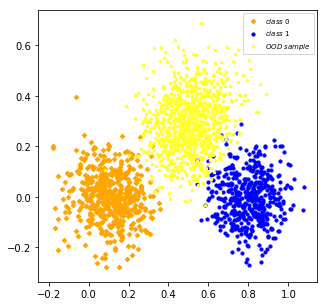

epoch: 12500
('d_loss', [0.6115029, 0.9])
('g_loss', [2.2667153, 0.8216327, 1.4450825, 0.06, 1.4450825])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.019309807803481818, 1.0])


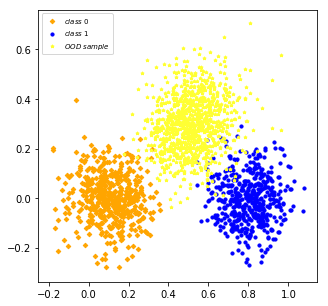

epoch: 12600
('d_loss', [0.6146924, 0.865])
('g_loss', [2.2663307, 0.8297806, 1.4365503, 0.08, 1.4365503])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.019680470891296865, 1.0])


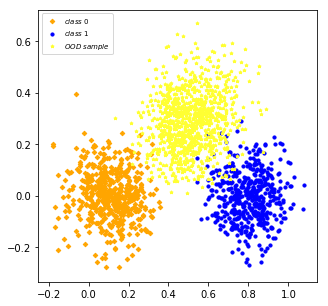

epoch: 12700
('d_loss', [0.60847783, 0.88])
('g_loss', [2.240728, 0.82248414, 1.4182439, 0.03, 1.4182439])
1000/1000 [==============================] - 0s 30us/step
('c_loss:', [0.019766966113820672, 1.0])


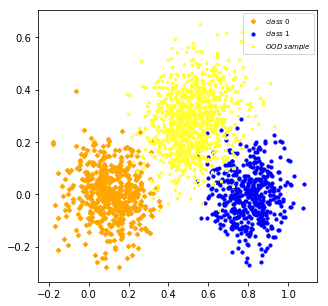

epoch: 12800
('d_loss', [0.60868526, 0.89])
('g_loss', [2.2523758, 0.8280651, 1.4243108, 0.01, 1.4243108])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.020414549631997944, 1.0])


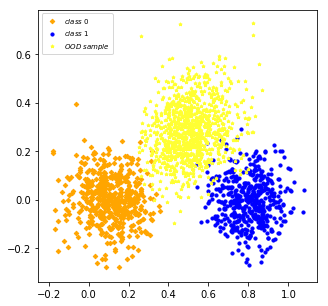

epoch: 12900
('d_loss', [0.6111757, 0.89])
('g_loss', [2.2396393, 0.8304452, 1.4091942, 0.04, 1.4091942])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.0200623995680362, 1.0])


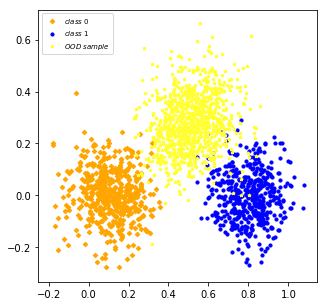

epoch: 13000
('d_loss', [0.6094726, 0.88])
('g_loss', [2.2580376, 0.815457, 1.4425805, 0.07, 1.4425805])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.02058744514733553, 1.0])


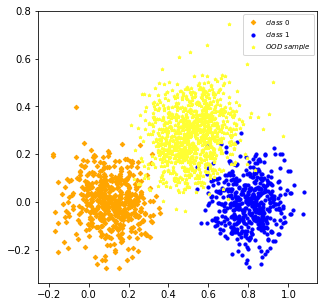

epoch: 13100
('d_loss', [0.60390985, 0.895])
('g_loss', [2.2725515, 0.84626275, 1.4262887, 0.03, 1.4262887])
1000/1000 [==============================] - 0s 28us/step
('c_loss:', [0.020812246173620225, 1.0])


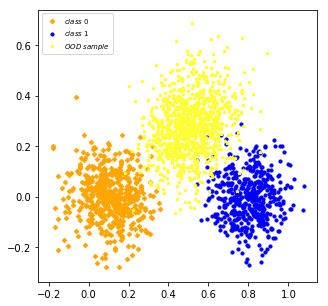

epoch: 13200
('d_loss', [0.6083595, 0.89])
('g_loss', [2.2602904, 0.833817, 1.4264734, 0.05, 1.4264734])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.021439359426498415, 1.0])


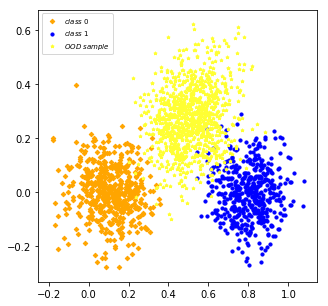

epoch: 13300
('d_loss', [0.6046552, 0.885])
('g_loss', [2.345597, 0.8250724, 1.5205246, 0.05, 1.5205246])
1000/1000 [==============================] - 0s 26us/step
('c_loss:', [0.021578321292996406, 1.0])


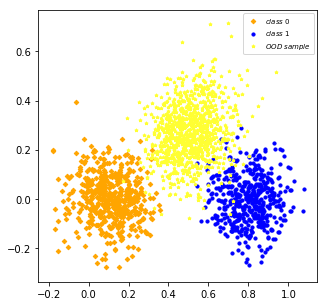

epoch: 13400
('d_loss', [0.61081535, 0.85])
('g_loss', [2.2739666, 0.82940596, 1.4445605, 0.05, 1.4445605])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.021762558285146952, 1.0])


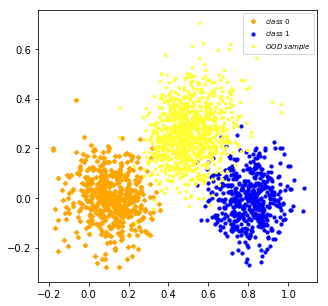

epoch: 13500
('d_loss', [0.5956091, 0.925])
('g_loss', [2.2992067, 0.82821274, 1.470994, 0.05, 1.470994])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.021939935754984617, 1.0])


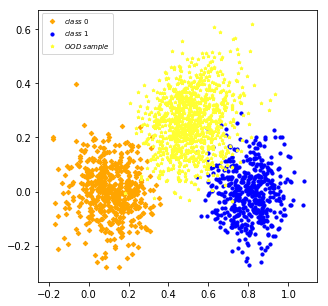

epoch: 13600
('d_loss', [0.5974018, 0.905])
('g_loss', [2.2585468, 0.84231216, 1.4162347, 0.06, 1.4162347])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.022102636888623236, 1.0])


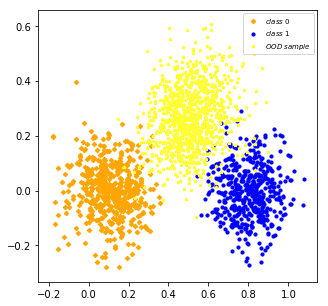

epoch: 13700
('d_loss', [0.6094539, 0.86])
('g_loss', [2.2289374, 0.8134913, 1.415446, 0.09, 1.415446])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.02311407209187746, 1.0])


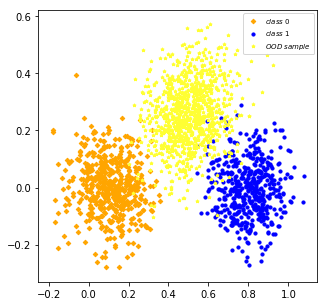

epoch: 13800
('d_loss', [0.6040653, 0.875])
('g_loss', [2.2312026, 0.83988875, 1.3913138, 0.02, 1.3913138])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.023150357697159053, 1.0])


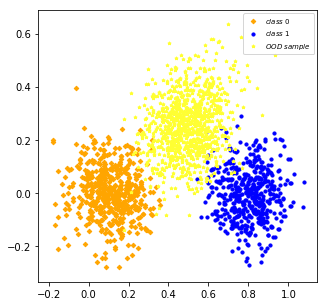

epoch: 13900
('d_loss', [0.60571116, 0.86])
('g_loss', [2.245505, 0.8254985, 1.4200065, 0.07, 1.4200065])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.023170594073832033, 1.0])


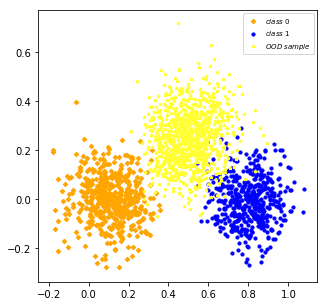

epoch: 14000
('d_loss', [0.61093116, 0.83])
('g_loss', [2.3443065, 0.8308395, 1.5134668, 0.1, 1.5134668])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.02288802284002304, 1.0])


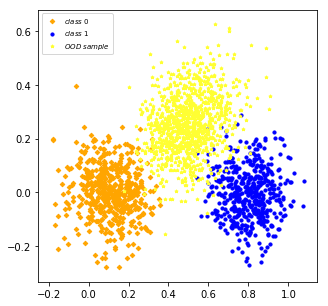

epoch: 14100
('d_loss', [0.60363144, 0.86])
('g_loss', [2.2510533, 0.82467026, 1.426383, 0.07, 1.426383])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.02459750820696354, 1.0])


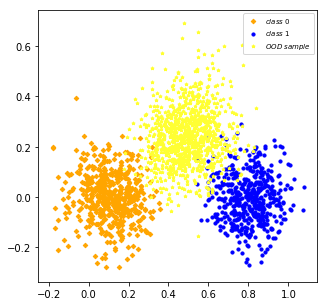

epoch: 14200
('d_loss', [0.6108282, 0.87])
('g_loss', [2.2575164, 0.8269398, 1.4305764, 0.05, 1.4305764])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.025061774156987668, 1.0])


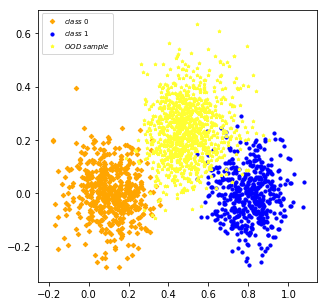

epoch: 14300
('d_loss', [0.60543954, 0.88])
('g_loss', [2.251459, 0.81515723, 1.4363017, 0.13, 1.4363017])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.025701750107109546, 1.0])


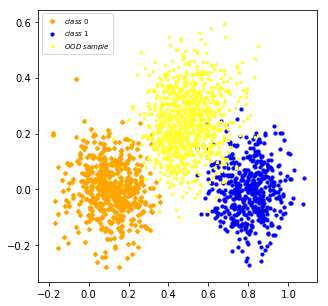

epoch: 14400
('d_loss', [0.59956986, 0.9])
('g_loss', [2.3071694, 0.8283447, 1.4788246, 0.09, 1.4788246])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.026432543344795705, 1.0])


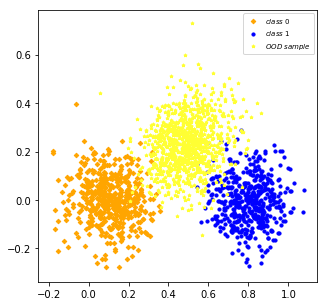

epoch: 14500
('d_loss', [0.60490996, 0.855])
('g_loss', [2.2260008, 0.8221239, 1.4038769, 0.07, 1.4038769])
1000/1000 [==============================] - 0s 20us/step
('c_loss:', [0.027643712855875493, 1.0])


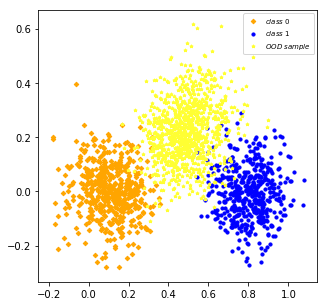

epoch: 14600
('d_loss', [0.61200666, 0.83])
('g_loss', [2.30728, 0.8333892, 1.4738908, 0.1, 1.4738908])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.028268000796437265, 1.0])


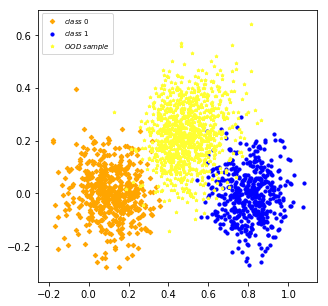

epoch: 14700
('d_loss', [0.595904, 0.87])
('g_loss', [2.2708697, 0.82257307, 1.4482967, 0.09, 1.4482967])
1000/1000 [==============================] - 0s 17us/step
('c_loss:', [0.028885765127837658, 1.0])


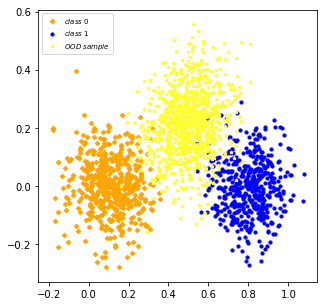

epoch: 14800
('d_loss', [0.610245, 0.86])
('g_loss', [2.2298317, 0.8115046, 1.418327, 0.1, 1.418327])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.02930818537995219, 1.0])


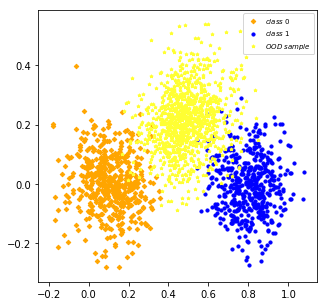

epoch: 14900
('d_loss', [0.60823035, 0.825])
('g_loss', [2.287067, 0.8231048, 1.4639622, 0.11, 1.4639622])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.02977195532247424, 1.0])


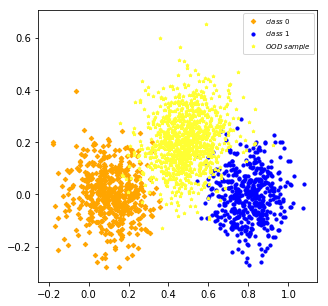

epoch: 15000
('d_loss', [0.6112293, 0.835])
('g_loss', [2.225633, 0.82373995, 1.401893, 0.04, 1.401893])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.03115102571994066, 1.0])


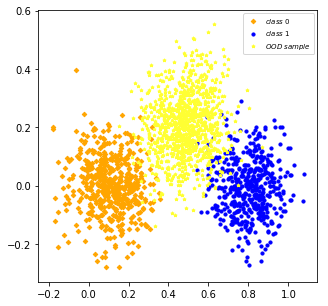

epoch: 15100
('d_loss', [0.61540407, 0.835])
('g_loss', [2.2659397, 0.8115307, 1.4544091, 0.14, 1.4544091])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.031201607182621955, 1.0])


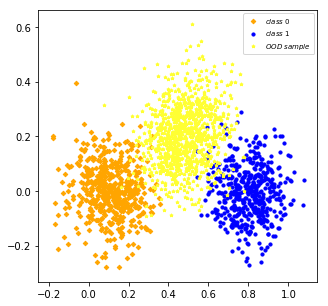

epoch: 15200
('d_loss', [0.6076653, 0.84])
('g_loss', [2.235835, 0.8173296, 1.4185055, 0.09, 1.4185055])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.03106370059773326, 1.0])


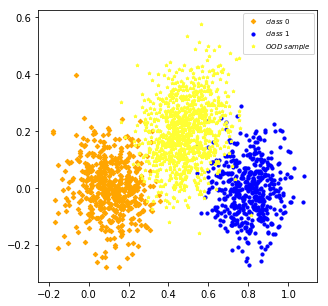

epoch: 15300
('d_loss', [0.6030169, 0.82])
('g_loss', [2.2373385, 0.8222253, 1.4151133, 0.08, 1.4151133])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.03181837309896946, 1.0])


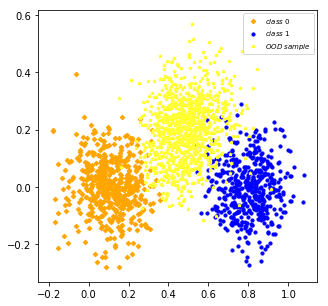

epoch: 15400
('d_loss', [0.605686, 0.86])
('g_loss', [2.2731538, 0.81118226, 1.4619716, 0.14, 1.4619716])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.032254174336791036, 1.0])


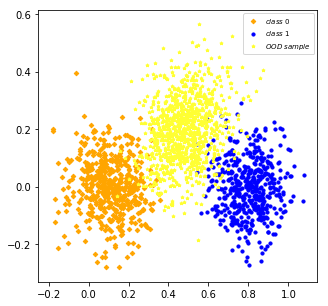

epoch: 15500
('d_loss', [0.6064375, 0.855])
('g_loss', [2.2506952, 0.8049456, 1.4457498, 0.18, 1.4457498])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.03312867726385593, 1.0])


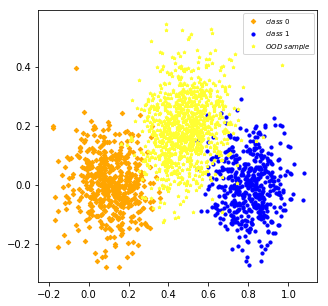

epoch: 15600
('d_loss', [0.6105219, 0.82])
('g_loss', [2.2788215, 0.8203602, 1.4584612, 0.09, 1.4584612])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.033295095078647134, 1.0])


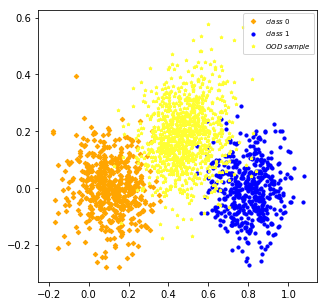

epoch: 15700
('d_loss', [0.6066046, 0.825])
('g_loss', [2.276382, 0.7898363, 1.4865457, 0.21, 1.4865457])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.033959521904587744, 1.0])


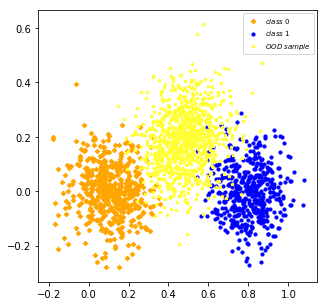

epoch: 15800
('d_loss', [0.6191188, 0.775])
('g_loss', [2.266265, 0.821986, 1.4442788, 0.15, 1.4442788])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.034825436517596245, 1.0])


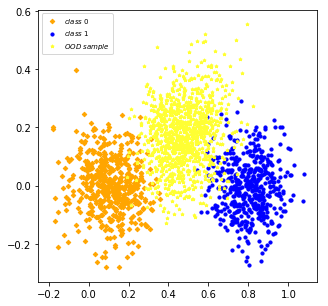

epoch: 15900
('d_loss', [0.5984838, 0.81])
('g_loss', [2.2750819, 0.82359344, 1.4514885, 0.06, 1.4514885])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.036466404378414155, 1.0])


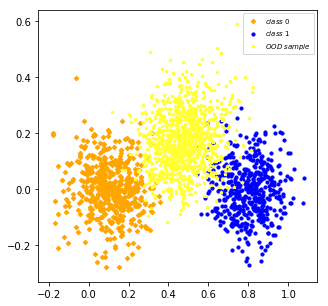

epoch: 16000
('d_loss', [0.61639994, 0.785])
('g_loss', [2.2602134, 0.8042734, 1.4559399, 0.18, 1.4559399])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.037362086266279224, 1.0])


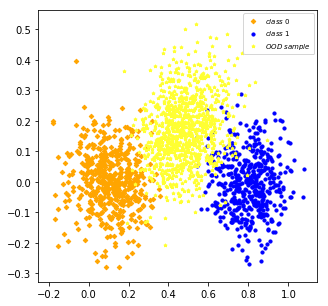

epoch: 16100
('d_loss', [0.60912824, 0.77])
('g_loss', [2.2445285, 0.81051475, 1.4340137, 0.15, 1.4340137])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.03853060501068831, 1.0])


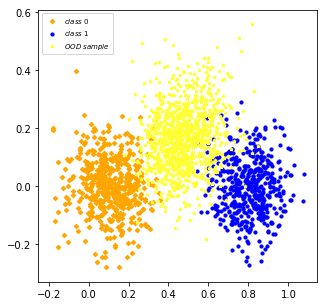

epoch: 16200
('d_loss', [0.61865366, 0.82])
('g_loss', [2.2961066, 0.80440414, 1.4917024, 0.15, 1.4917024])
1000/1000 [==============================] - 0s 17us/step
('c_loss:', [0.039016266293823716, 1.0])


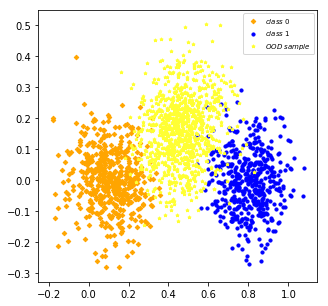

epoch: 16300
('d_loss', [0.6185615, 0.755])
('g_loss', [2.2410722, 0.80148894, 1.4395832, 0.23, 1.4395832])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.039349588602781295, 1.0])


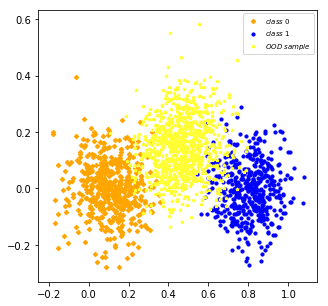

epoch: 16400
('d_loss', [0.6185997, 0.765])
('g_loss', [2.3179317, 0.7817528, 1.5361787, 0.26, 1.5361787])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.041655483476817606, 1.0])


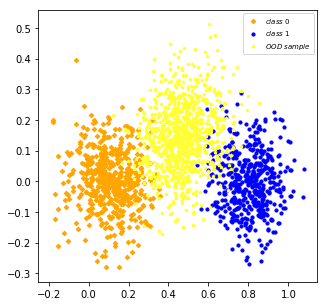

epoch: 16500
('d_loss', [0.6146316, 0.82])
('g_loss', [2.215574, 0.8039774, 1.4115967, 0.18, 1.4115967])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.04227316012978554, 1.0])


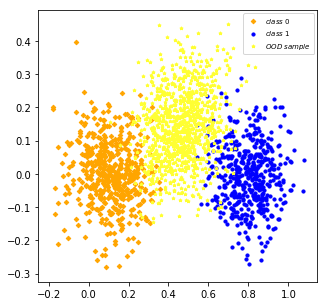

epoch: 16600
('d_loss', [0.622221, 0.805])
('g_loss', [2.30238, 0.7992197, 1.5031604, 0.23, 1.5031604])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.043270198173820974, 1.0])


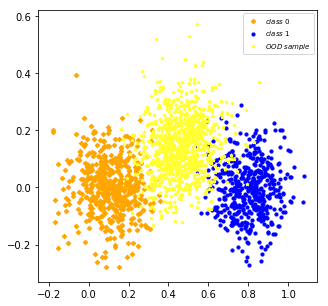

epoch: 16700
('d_loss', [0.6162038, 0.785])
('g_loss', [2.285129, 0.7823056, 1.5028236, 0.23, 1.5028236])
1000/1000 [==============================] - 0s 26us/step
('c_loss:', [0.04532042956352234, 1.0])


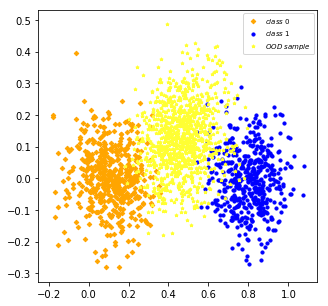

epoch: 16800
('d_loss', [0.6304412, 0.765])
('g_loss', [2.2012677, 0.7734082, 1.4278597, 0.25, 1.4278597])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.04676526744663716, 1.0])


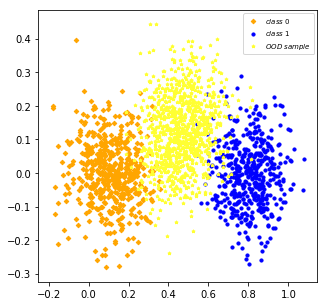

epoch: 16900
('d_loss', [0.6363132, 0.715])
('g_loss', [2.2031548, 0.7716742, 1.4314805, 0.27, 1.4314805])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.04747961412370205, 1.0])


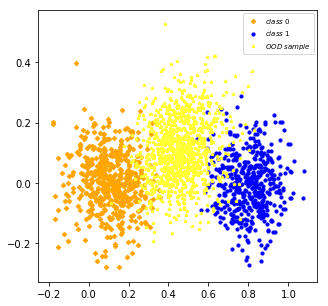

epoch: 17000
('d_loss', [0.62364775, 0.745])
('g_loss', [2.2129714, 0.7719533, 1.4410182, 0.28, 1.4410182])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.049174137935042384, 1.0])


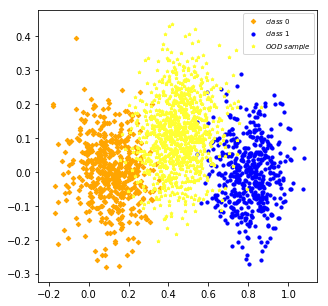

epoch: 17100
('d_loss', [0.62485933, 0.755])
('g_loss', [2.226607, 0.7640108, 1.4625963, 0.34, 1.4625963])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.04938135784864426, 1.0])


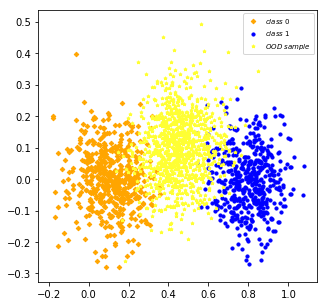

epoch: 17200
('d_loss', [0.6475606, 0.655])
('g_loss', [2.213489, 0.7480777, 1.4654114, 0.35, 1.4654114])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05047749806940555, 1.0])


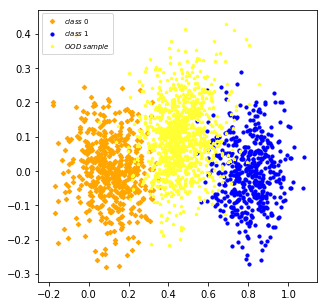

epoch: 17300
('d_loss', [0.63685095, 0.69])
('g_loss', [2.300188, 0.7572461, 1.542942, 0.34, 1.542942])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05238021852076054, 1.0])


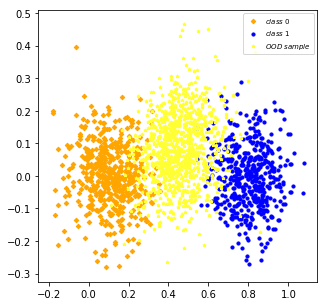

epoch: 17400
('d_loss', [0.63375, 0.73])
('g_loss', [2.222908, 0.76338196, 1.4595261, 0.36, 1.4595261])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05505597618222237, 1.0])


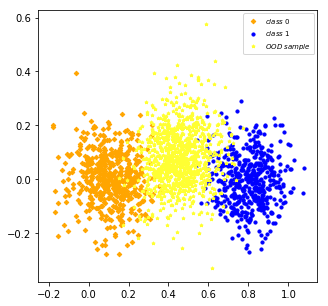

epoch: 17500
('d_loss', [0.6423538, 0.67])
('g_loss', [2.1780126, 0.7331699, 1.4448427, 0.38, 1.4448427])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05539906065165996, 1.0])


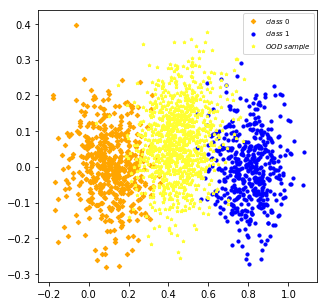

epoch: 17600
('d_loss', [0.65071845, 0.645])
('g_loss', [2.22622, 0.73378754, 1.4924324, 0.44, 1.4924324])
1000/1000 [==============================] - 0s 24us/step
('c_loss:', [0.05794672167301178, 1.0])


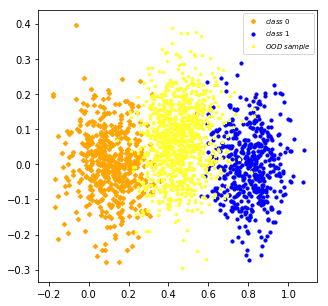

epoch: 17700
('d_loss', [0.66129655, 0.65])
('g_loss', [2.1871576, 0.7223656, 1.4647921, 0.46, 1.4647921])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.059268240094184875, 1.0])


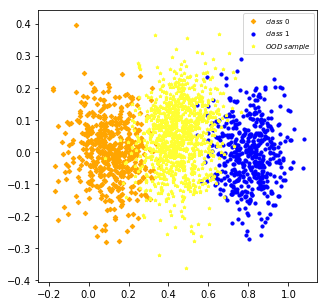

epoch: 17800
('d_loss', [0.6710687, 0.63])
('g_loss', [2.1787271, 0.7206664, 1.4580607, 0.45, 1.4580607])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06212202623486519, 1.0])


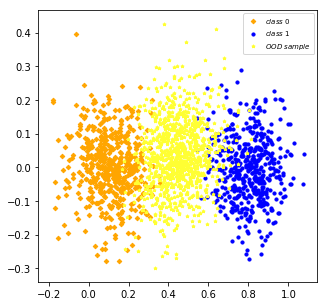

epoch: 17900
('d_loss', [0.6711715, 0.575])
('g_loss', [2.1613336, 0.71017164, 1.4511619, 0.43, 1.4511619])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06220654779672623, 1.0])


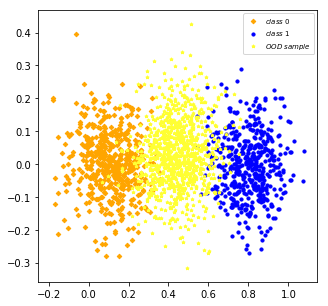

epoch: 18000
('d_loss', [0.67377913, 0.595])
('g_loss', [2.1436028, 0.70258796, 1.4410148, 0.45, 1.4410148])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06406764882802964, 1.0])


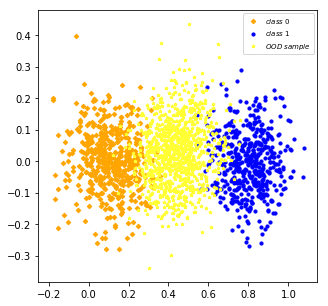

epoch: 18100
('d_loss', [0.68596977, 0.53])
('g_loss', [2.200028, 0.6834767, 1.5165514, 0.56, 1.5165514])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06579837346076965, 1.0])


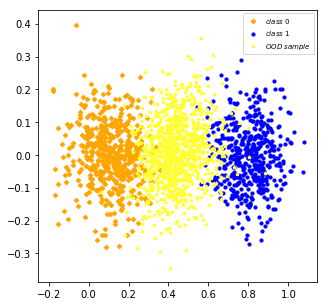

epoch: 18200
('d_loss', [0.6885694, 0.525])
('g_loss', [2.2163286, 0.6737857, 1.542543, 0.58, 1.542543])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06676508930325509, 1.0])


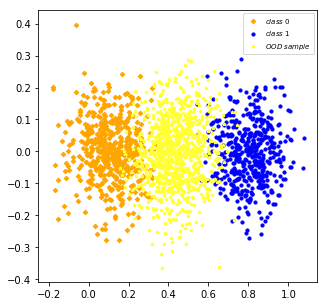

epoch: 18300
('d_loss', [0.69734883, 0.53])
('g_loss', [2.1991978, 0.6506272, 1.5485705, 0.68, 1.5485705])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06616077208518982, 1.0])


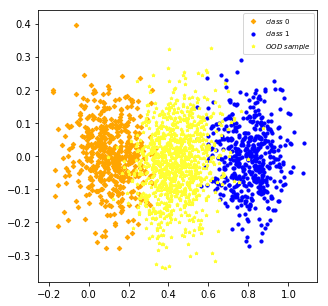

epoch: 18400
('d_loss', [0.70750105, 0.505])
('g_loss', [2.1345563, 0.6549456, 1.4796106, 0.63, 1.4796106])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.0676045484393835, 1.0])


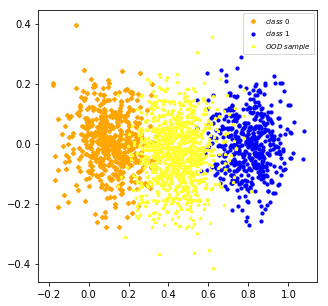

epoch: 18500
('d_loss', [0.7116162, 0.455])
('g_loss', [2.0664697, 0.6187622, 1.4477074, 0.8, 1.4477074])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06783015812933445, 1.0])


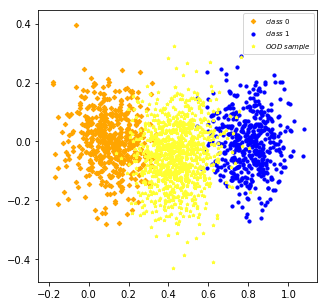

epoch: 18600
('d_loss', [0.7193708, 0.435])
('g_loss', [2.0723944, 0.6281607, 1.4442337, 0.78, 1.4442337])
1000/1000 [==============================] - 0s 27us/step
('c_loss:', [0.06740669256448746, 1.0])


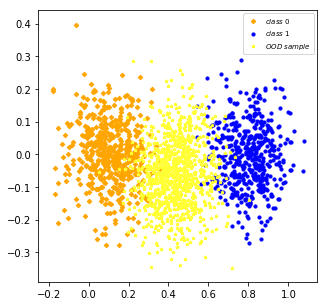

epoch: 18700
('d_loss', [0.72675914, 0.4])
('g_loss', [2.1068377, 0.61150885, 1.4953288, 0.79, 1.4953288])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06813973936438561, 1.0])


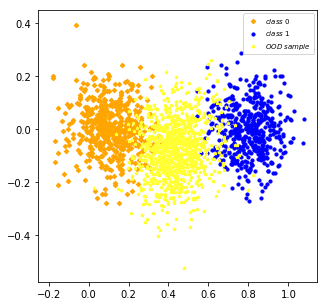

epoch: 18800
('d_loss', [0.7416945, 0.35])
('g_loss', [2.0828493, 0.5953665, 1.4874828, 0.89, 1.4874828])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.06685510525107384, 1.0])


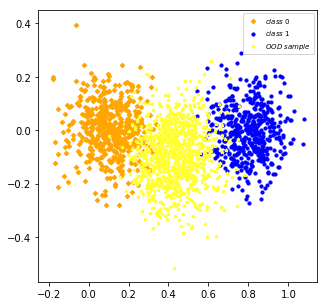

epoch: 18900
('d_loss', [0.73315054, 0.39])
('g_loss', [2.0696142, 0.5888228, 1.4807914, 0.91, 1.4807914])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.06449433162808418, 1.0])


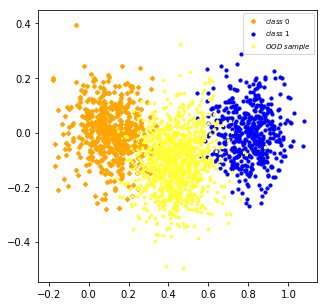

epoch: 19000
('d_loss', [0.739438, 0.385])
('g_loss', [2.0411239, 0.5884832, 1.4526407, 0.89, 1.4526407])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06277867877483367, 1.0])


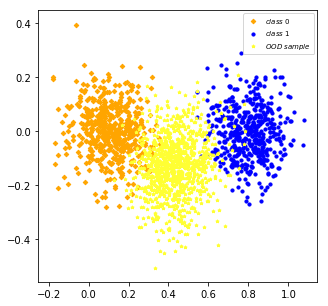

epoch: 19100
('d_loss', [0.73466647, 0.41])
('g_loss', [2.0340166, 0.5768872, 1.4571295, 0.95, 1.4571295])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.06223305669426918, 1.0])


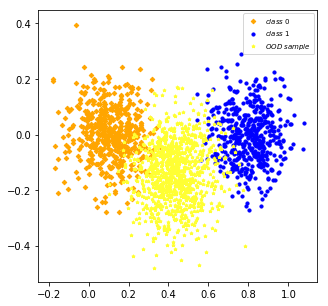

epoch: 19200
('d_loss', [0.7358609, 0.395])
('g_loss', [2.0448563, 0.5778666, 1.4669896, 0.94, 1.4669896])
1000/1000 [==============================] - 0s 19us/step
('c_loss:', [0.05929993160068989, 1.0])


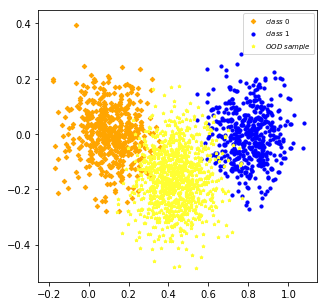

epoch: 19300
('d_loss', [0.738973, 0.375])
('g_loss', [2.0379784, 0.56735176, 1.4706267, 0.98, 1.4706267])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05639126804471016, 1.0])


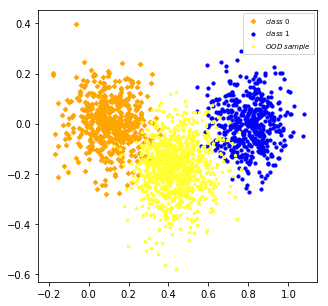

epoch: 19400
('d_loss', [0.75442284, 0.345])
('g_loss', [2.0237532, 0.5526294, 1.4711238, 0.99, 1.4711238])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.053827769055962565, 1.0])


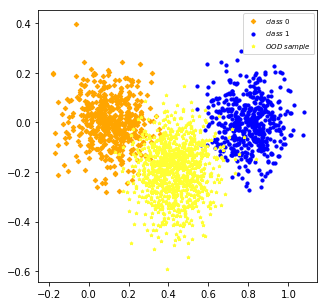

epoch: 19500
('d_loss', [0.7487962, 0.345])
('g_loss', [2.0213318, 0.5629007, 1.4584311, 0.96, 1.4584311])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.05175140377879143, 1.0])


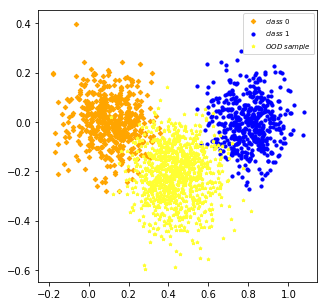

epoch: 19600
('d_loss', [0.7517488, 0.35])
('g_loss', [2.0047522, 0.557608, 1.4471442, 1.0, 1.4471442])
1000/1000 [==============================] - 0s 22us/step
('c_loss:', [0.047980223059654235, 1.0])


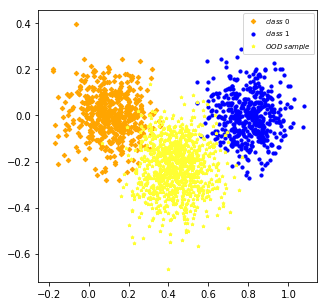

epoch: 19700
('d_loss', [0.7565054, 0.34])
('g_loss', [2.0232084, 0.5614142, 1.4617941, 0.99, 1.4617941])
1000/1000 [==============================] - 0s 21us/step
('c_loss:', [0.04491777011752129, 1.0])


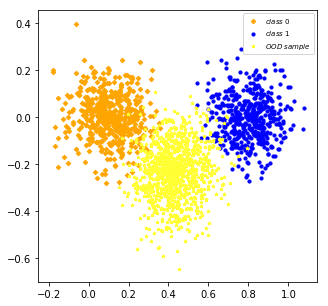

epoch: 19800
('d_loss', [0.74563336, 0.385])
('g_loss', [1.9704456, 0.56150186, 1.4089438, 0.99, 1.4089438])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.04188775670528412, 1.0])


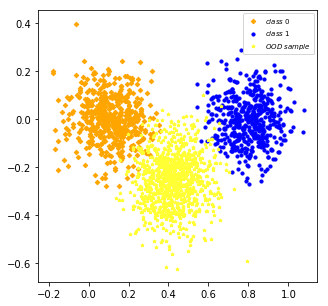

epoch: 19900
('d_loss', [0.7463714, 0.36])
('g_loss', [2.0039458, 0.5598926, 1.4440532, 1.0, 1.4440532])
1000/1000 [==============================] - 0s 18us/step
('c_loss:', [0.03933072327077389, 1.0])


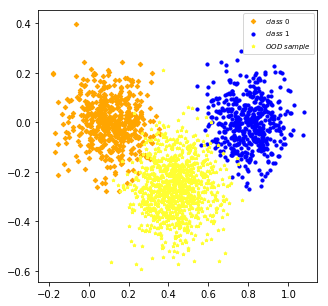

In [13]:
gan = GAN()
gan.train()